In [ ]:
!pip install cmu-multimodal-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.6 MB/s eta 0:00:00
  Created wheel for cmu-multimodal-sdk: filename=cmu_multimodal_sdk-0.0.6-py3-none-any.whl size=69467 sha256=808213754848c963d7b9b5c587ab6e6672e5fa4eca76460395e36d4a4e1f49b7
  Stored in directory: /root/.cache/pip/wheels/a9/b2/c2/fd013da0519bbc67543a5b25e76a2ca1763646842a5183b221
Successfully built cmu-multimodal-sdk


In [ ]:
!pip install huggingface_hub

In [ ]:
!pip install transformers

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import BertTokenizer, BertModel
from pathlib import Path
import logging
import math
import pickle
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
import time
from mmsdk import mmdatasdk as md
import sys
from prettytable import PrettyTable
import os
from huggingface_hub import login

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
The token `ml` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushin

In [ ]:
path = kagglehub.dataset_download("samarwarsi/cmu-mosei")
print('Data source import complete.')

Data source import complete.


In [ ]:
print(path)

/kaggle/input/cmu-mosei


In [ ]:
RAW_DATA_DIR = "/kaggle/input/cmu-mosei/CMU-MOSEI"
PROCESSED_DATA_DIR = "/content/processed_data"
DATASET_NAME = "CMU_MOSEI"
TEXT_MAX_LENGTH = 128
TEXT_EMBEDDING_DIM = 768
AUDIO_FEATURE_SIZE = 40
VISUAL_FEATURE_SIZE = 35
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_EPOCHS = 5
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5

In [ ]:
torch.manual_seed(SEED)
np.random.seed(SEED)

In [ ]:
class MOSEIDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data["labels"])

    def __getitem__(self, idx):
        return {
            "acoustic": torch.tensor(self.data["acoustic"][idx], dtype=torch.float32),
            "visual": torch.tensor(self.data["visual"][idx], dtype=torch.float32),
            "language": torch.tensor(self.data["language"][idx], dtype = torch.float32),
            "label": torch.tensor(self.data["labels"][idx], dtype=torch.float32)
        }


In [ ]:
class MOSEIPreprocessor:
    def __init__(self, raw_data_dir, processed_data_dir):
        self.raw_data_dir = Path(raw_data_dir)
        self.processed_data_dir = Path(processed_data_dir)
        self.processed_data_dir.mkdir(exist_ok=True, parents=True)

        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.bert_model = BertModel.from_pretrained("bert-base-uncased")
        self.bert_model.eval()
        self.device = DEVICE
        self.bert_model.to(self.device)
        print(f"Using device: {self.device}")

        self.data = {
           "train": {"language": [], "acoustic": [], "visual": [], "labels": []},
            "val": {"language": [], "acoustic": [], "visual": [], "labels": []},
            "test": {"language": [], "acoustic": [], "visual": [],  "labels": []}
        }

        self.metadata = {
            "text_dim": TEXT_EMBEDDING_DIM ,
            "audio_dim": AUDIO_FEATURE_SIZE,
            "visual_dim": VISUAL_FEATURE_SIZE,
            "num_classes": 1,
            "train_samples": 0,
            "val_samples": 0,
            "test_samples": 0
        }

    def load_aligned_data(self):
        print("Loading aligned data...")
        try:
            dataset = {
                "language": str(self.raw_data_dir /"languages"/ "CMU_MOSEI_TimestampedWords.csd"),
                "acoustic": str(self.raw_data_dir /"acoustics"/ "CMU_MOSEI_COVAREP.csd"),
                "visual": str(self.raw_data_dir /"visuals"/ "CMU_MOSEI_VisualOpenFace2.csd"),
                "labels": str(self.raw_data_dir /"labels"/ "CMU_MOSEI_Labels.csd")
            }
            for key, path in dataset.items():
                if not os.path.exists(path):
                    print(f"Error: File {path} does not exist")
                    return None
            mosei_dataset = md.mmdataset(dataset)
            print(f"Loaded dataset with {len(mosei_dataset['labels'].keys())} segments")
            return mosei_dataset
        except Exception as e:
            print(f"Error loading aligned data: {e}")
            return None

    def extract_text_features(self, text):
        try:
            inputs = self.tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=TEXT_MAX_LENGTH,
                return_tensors="pt"
            )
            inputs = {key: val.to(self.device) for key, val in inputs.items()}
            with torch.no_grad():
                # Explicitly move the model to the device before the forward pass
                self.bert_model.to(self.device)
                outputs = self.bert_model(**inputs)
                embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            return embeddings[0]

        except Exception as e:
            logger.error(f"Error extracting text features: {e}")
            return np.zeros(TEXT_EMBEDDING_DIM)

    def extract_audio_features(self, audio_features):
        if len(audio_features.shape) > 1 and audio_features.shape[0] > 0:
            selected_features = np.mean(audio_features, axis=0)
            if np.any(np.isnan(selected_features)):
                selected_features = np.nan_to_num(selected_features, nan=0.0)
            if len(selected_features) > AUDIO_FEATURE_SIZE:
                selected_features = selected_features[:AUDIO_FEATURE_SIZE]
            elif len(selected_features) < AUDIO_FEATURE_SIZE:
                selected_features = np.pad(selected_features, (0, AUDIO_FEATURE_SIZE - len(selected_features)))
            return selected_features
        return np.zeros(AUDIO_FEATURE_SIZE)

    def extract_visual_features(self, visual_features):
        if len(visual_features.shape) > 1 and visual_features.shape[0] > 0:
            selected_features = np.mean(visual_features, axis=0)
            if np.any(np.isnan(selected_features)):
                selected_features = np.nan_to_num(selected_features, nan=0.0)
            if len(selected_features) > VISUAL_FEATURE_SIZE:
                selected_features = selected_features[:VISUAL_FEATURE_SIZE]
            elif len(selected_features) < VISUAL_FEATURE_SIZE:
                selected_features = np.pad(selected_features, (0, VISUAL_FEATURE_SIZE - len(selected_features)))
            return selected_features
        return np.zeros(VISUAL_FEATURE_SIZE)

    def process_dataset(self):
        print("Preprocessing dataset...")
        dataset = self.load_aligned_data()
        if dataset is None:
            print("Cannot loading dataset")
            return False

        segment_ids = list(dataset["labels"].keys())
        print(f"Find {len(segment_ids)} segment in dataset")

        train_ids, test_ids = train_test_split(segment_ids, test_size=0.2, random_state=SEED)
        train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=SEED)

        splits = {"train": train_ids, "val": val_ids, "test": test_ids}

        for split_name, split_ids in splits.items():
            print(f"Processing file {split_name} with {len(split_ids)} segment")
            for segment_id in tqdm(split_ids, desc=f"Preprocessing {split_name}"):
                try:
                    text_features = dataset["language"][segment_id]["features"]
                    audio_features = dataset["acoustic"][segment_id]["features"]
                    visual_features = dataset["visual"][segment_id]["features"]
                    label = dataset["labels"][segment_id]["features"]

                    text_str = " ".join([word[0].decode('utf-8') if isinstance(word[0], bytes) else str(word[0]) for word in text_features])

                    text_embedding = self.extract_text_features(text_str)
                    audio_embedding = self.extract_audio_features(audio_features)
                    visual_embedding = self.extract_visual_features(visual_features)
                    sentiment_score = np.mean(label)

                    if np.isnan(sentiment_score):
                        continue
                    self.data[split_name]["language"].append(text_embedding)
                    self.data[split_name]["acoustic"].append(audio_embedding)
                    self.data[split_name]["visual"].append(visual_embedding)
                    self.data[split_name]["labels"].append(sentiment_score)
                except Exception as e:
                    print(f"Error while processing segment {segment_id}: {e}")
                    continue

            self.metadata[f"{split_name}_samples"] = len(self.data[split_name]["labels"])
            print(f"Set {split_name} có {self.metadata[f'{split_name}_samples']} mẫu")
        print(f"Các khóa trong self.data[{split_name}]: {list(self.data[split_name].keys())}")
        print("Dataset processing complete")
        return True

    def save_processed_data(self):
        print("Saving processed data...")
        for split_name in ["train", "val", "test"]:
            for modality in ["language", "acoustic", "visual", "labels"]:
                self.data[split_name][modality] = np.array(self.data[split_name][modality])
                if np.any(np.isnan(self.data[split_name][modality])):
                    self.data[split_name][modality] = np.nan_to_num(self.data[split_name][modality], nan=0.0)

            split_file = self.processed_data_dir / f"{split_name}_data.pkl"
            with open(split_file, "wb") as f:
                pickle.dump(self.data[split_name], f)
            print(f"Saved data {split_name} vào {split_file}")

        metadata_file = self.processed_data_dir / "metadata.pkl"
        with open(metadata_file, "wb") as f:
            pickle.dump(self.metadata, f)
        print(f"Saved metadata to {metadata_file}")

In [ ]:
preprocessor = MOSEIPreprocessor(RAW_DATA_DIR, PROCESSED_DATA_DIR)
print("Preprocessing dataset...")
if not preprocessor.process_dataset():
    print("Can not process dataset")
    # return

print("Saving processed data...")
preprocessor.save_processed_data()

train_dataset = MOSEIDataset(preprocessor.data["train"])
val_dataset = MOSEIDataset(preprocessor.data["val"])
test_dataset = MOSEIDataset(preprocessor.data["test"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Using device: cuda
Preprocessing dataset...
Preprocessing dataset...
Loading aligned data...
<Success>: Computational sequence read from file /kaggle/input/cmu-mosei/CMU-MOSEI/languages/CMU_MOSEI_TimestampedWords.csd ...
<Status>: Checking the integrity of the data in <b'"words"'> computational sequence ...


<Success>: <b'"words"'> computational sequence data in correct format.
<Status>: Checking the integrity of the metadata in <b'"words"'> computational sequence ...
<Success>: <b'"words"'> computational sequence metadata in correct format
<Success>: Computational sequence read from file /kaggle/input/cmu-mosei/CMU-MOSEI/acoustics/CMU_MOSEI_COVAREP.csd ...
<Status>: Checking the integrity of the data in <b'"COVAREP"'> computational sequence ...


<Success>: <b'"COVAREP"'> computational sequence data in correct format.
<Status>: Checking the integrity of the metadata in <b'"COVAREP"'> computational sequence ...
<Success>: <b'"COVAREP"'> computational sequence metadata in correct format
<Success>: Computational sequence read from file /kaggle/input/cmu-mosei/CMU-MOSEI/visuals/CMU_MOSEI_VisualOpenFace2.csd ...
<Status>: Checking the integrity of the data in <b'"OpenFace_2"'> computational sequence ...


<Success>: <b'"OpenFace_2"'> computational sequence data in correct format.
<Status>: Checking the integrity of the metadata in <b'"OpenFace_2"'> computational sequence ...
<Success>: <b'"OpenFace_2"'> computational sequence metadata in correct format
<Success>: Computational sequence read from file /kaggle/input/cmu-mosei/CMU-MOSEI/labels/CMU_MOSEI_Labels.csd ...
<Status>: Checking the integrity of the data in <b'"All Labels"'> computational sequence ...


<Success>: <b'"All Labels"'> computational sequence data in correct format.
<Status>: Checking the integrity of the metadata in <b'"All Labels"'> computational sequence ...
<Success>: <b'"All Labels"'> computational sequence metadata in correct format
<Success>: Dataset initialized successfully ... 
Loaded dataset with 3293 segments
Find 3293 segment in dataset
Processing file train with 2370 segment


Preprocessing train: 100%|██████████| 2370/2370 [07:59<00:00,  4.95it/s]


Set train có 2370 mẫu
Processing file val with 264 segment


Preprocessing val: 100%|██████████| 264/264 [00:53<00:00,  4.90it/s]


Set val có 264 mẫu
Processing file test with 659 segment


Preprocessing test:  82%|████████▏ | 543/659 [01:52<00:16,  7.09it/s]

Error while processing segment PEBwwe0PLZ8: 'PEBwwe0PLZ8'


Preprocessing test: 100%|██████████| 659/659 [02:17<00:00,  4.81it/s]


Set test có 658 mẫu
Các khóa trong self.data[test]: ['language', 'acoustic', 'visual', 'labels']
Dataset processing complete
Saving processed data...
Saving processed data...
Saved data train vào /content/processed_data/train_data.pkl
Saved data val vào /content/processed_data/val_data.pkl
Saved data test vào /content/processed_data/test_data.pkl
Saved metadata to /content/processed_data/metadata.pkl


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
print(f"Created DataLoader: Train={len(train_loader.dataset)}, Val={len(val_loader.dataset)}, Test={len(test_loader.dataset)}")

Created DataLoader: Train=2370, Val=264, Test=658


In [ ]:
batch = next(iter(train_loader))

sample = {k: v[0] for k, v in batch.items()}

# In ra thông tin
print("Label (sentiment score):", sample["label"].item())
print("Text features shape:", sample["language"].shape)
print("Audio features shape:", sample["acoustic"].shape)
print("Visual features shape:", sample["visual"].shape)


Label (sentiment score): -0.00501252943649888
Text features shape: torch.Size([768])
Audio features shape: torch.Size([40])
Visual features shape: torch.Size([35])


In [ ]:
all_text = []
all_audio = []
all_visual = []
all_labels = []

for batch in train_loader:
    all_text.append(batch["language"])
    all_audio.append(batch["acoustic"])
    all_visual.append(batch["visual"])
    all_labels.append(batch["label"])

X_text = torch.cat(all_text, dim=0).numpy()
X_audio = torch.cat(all_audio, dim=0).numpy()
X_visual = torch.cat(all_visual, dim=0).numpy()
y = torch.cat(all_labels, dim=0).numpy().squeeze()


In [ ]:
X_all = np.concatenate([X_text, X_audio, X_visual], axis=1)

df = pd.DataFrame(X_all)
df["label"] = y

In [ ]:
correlation_with_label = df.corr()["label"][:-1]


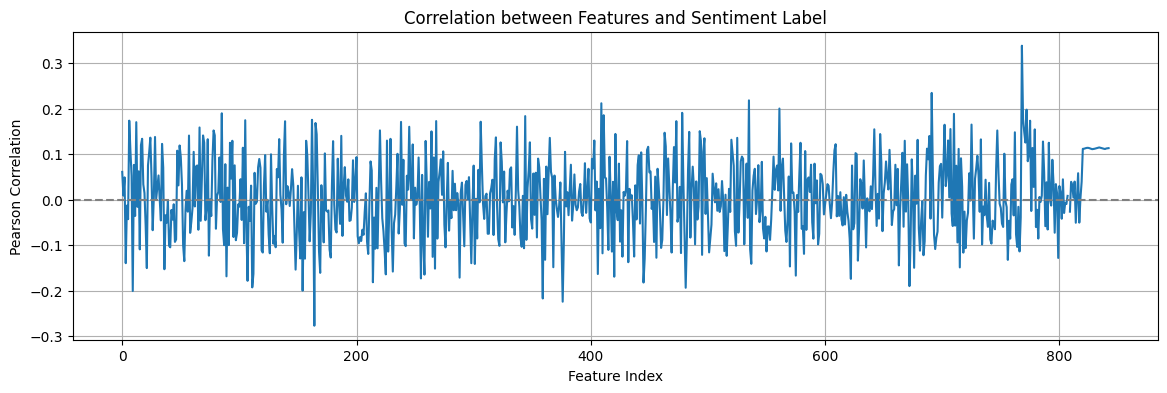

In [ ]:
plt.figure(figsize=(14, 4))
plt.plot(correlation_with_label.values)
plt.title("Correlation between Features and Sentiment Label")
plt.xlabel("Feature Index")
plt.ylabel("Pearson Correlation")
plt.axhline(0, color="gray", linestyle="--")
plt.grid(True)
plt.show()


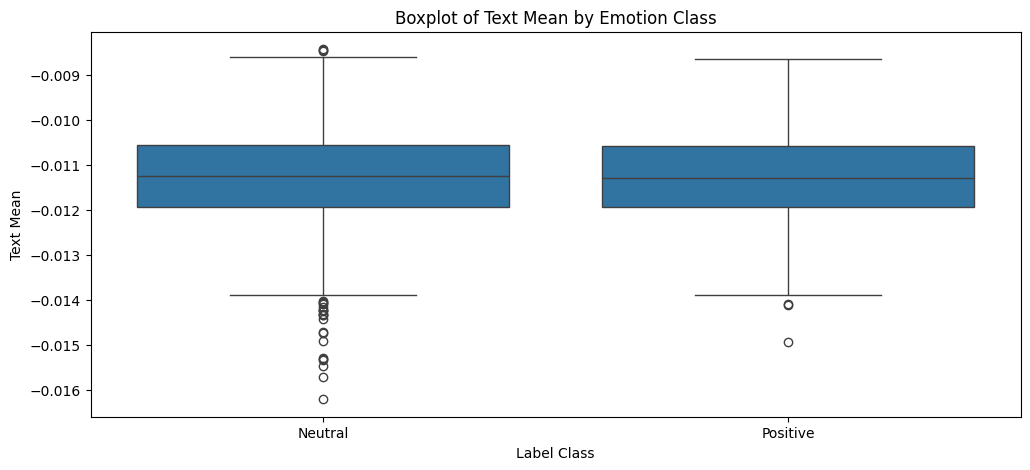

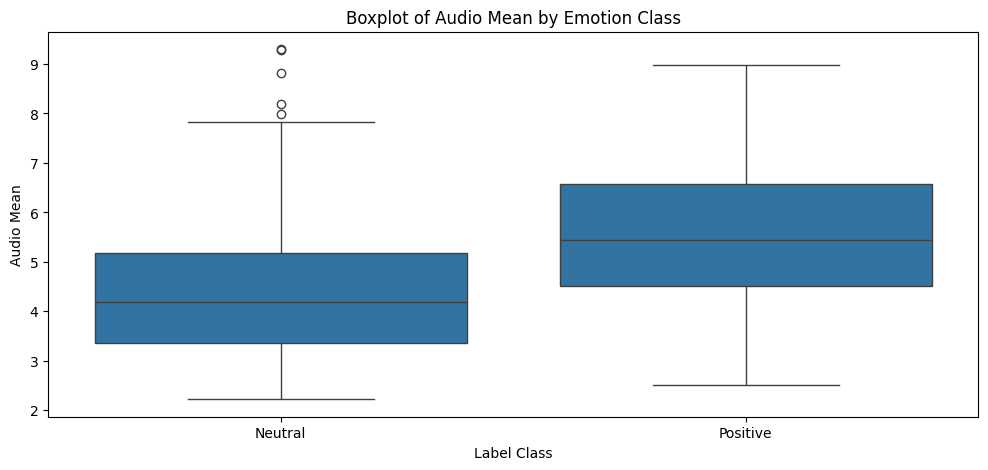

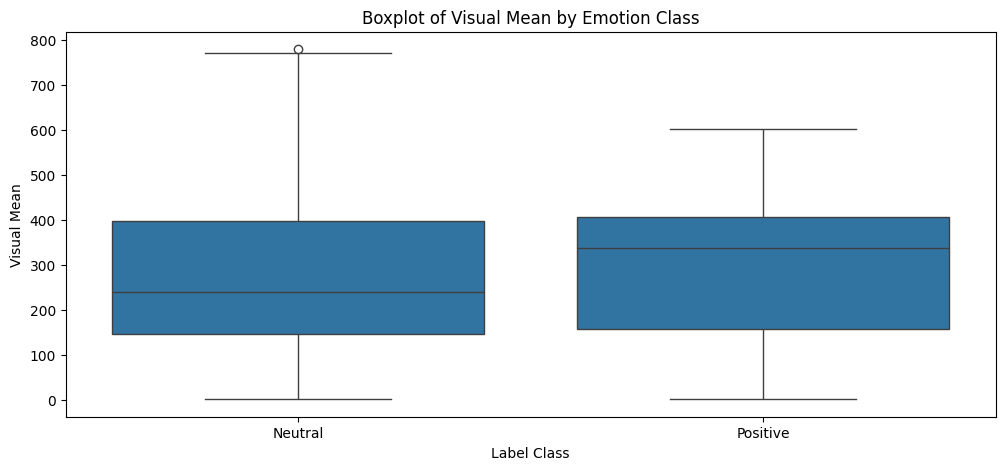

In [ ]:
def label_to_class(val):
    if val < -0.33: return "Negative"
    elif val > 0.33: return "Positive"
    else: return "Neutral"

label_classes = np.array([label_to_class(val) for val in y])

text_mean = np.mean(X_text, axis=1)
audio_mean = np.mean(X_audio, axis=1)
visual_mean = np.mean(X_visual, axis=1)

df_plot = pd.DataFrame({
    "Text Mean": text_mean,
    "Audio Mean": audio_mean,
    "Visual Mean": visual_mean,
    "Label Class": label_classes
})

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_plot, x="Label Class", y="Text Mean")
plt.title("Boxplot of Text Mean by Emotion Class")
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_plot, x="Label Class", y="Audio Mean")
plt.title("Boxplot of Audio Mean by Emotion Class")
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_plot, x="Label Class", y="Visual Mean")
plt.title("Boxplot of Visual Mean by Emotion Class")
plt.show()


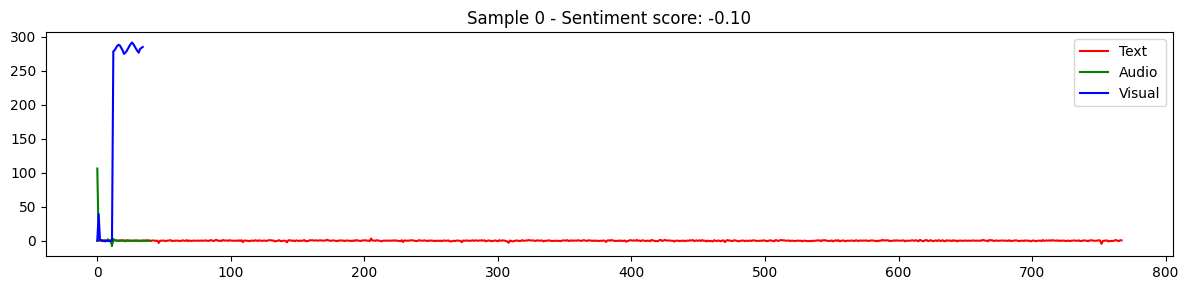

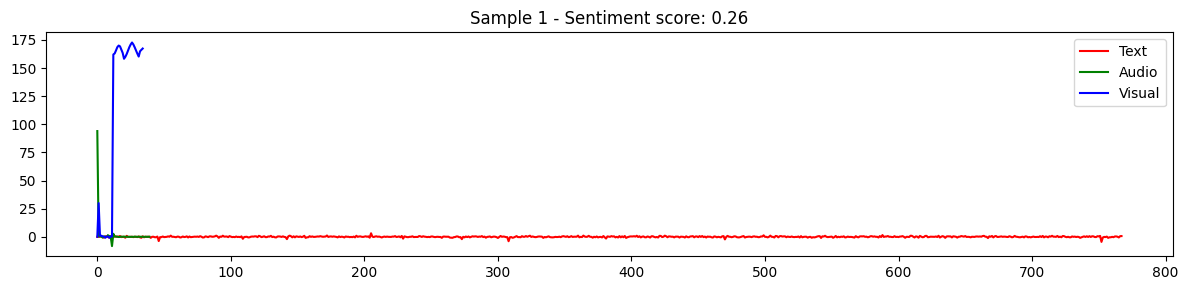

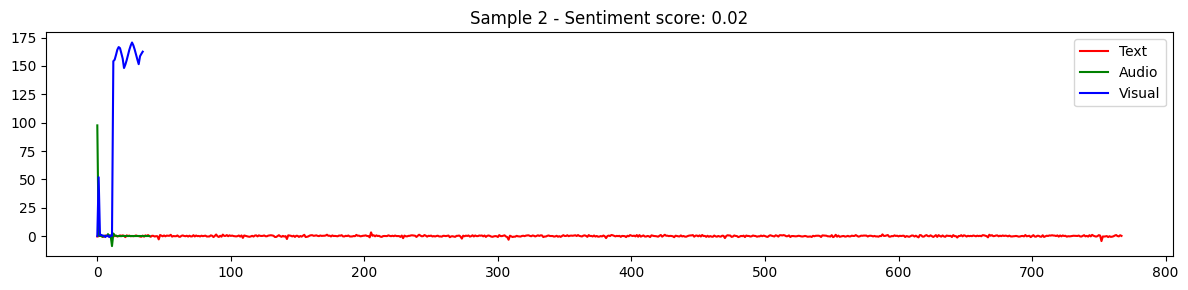

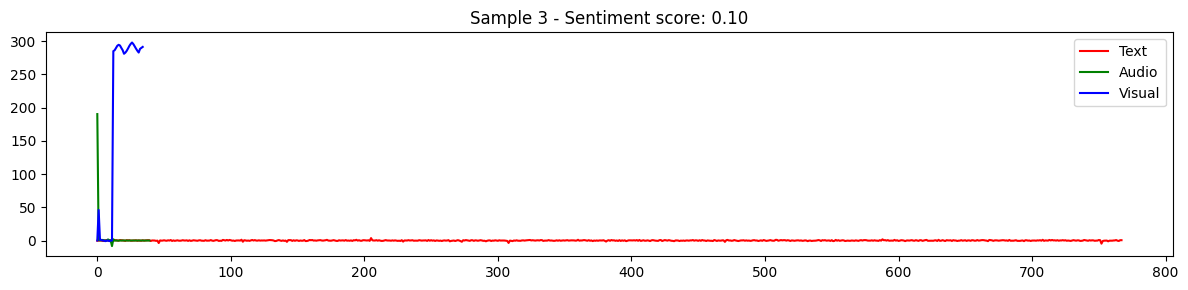

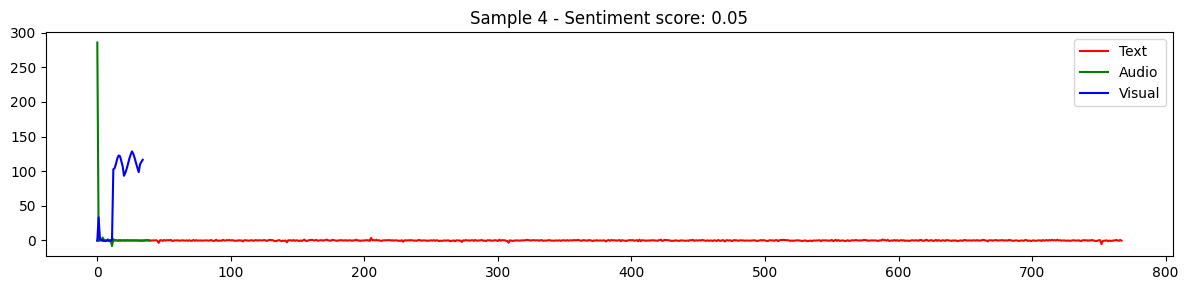

In [ ]:
for i in range(5):
    plt.figure(figsize=(12, 3))
    plt.plot(X_text[i], label="Text", color="red")
    plt.plot(X_audio[i], label="Audio", color="green")
    plt.plot(X_visual[i], label="Visual", color="blue")
    plt.title(f"Sample {i} - Sentiment score: {y[i]:.2f}")
    plt.legend()
    plt.tight_layout()
    plt.show()


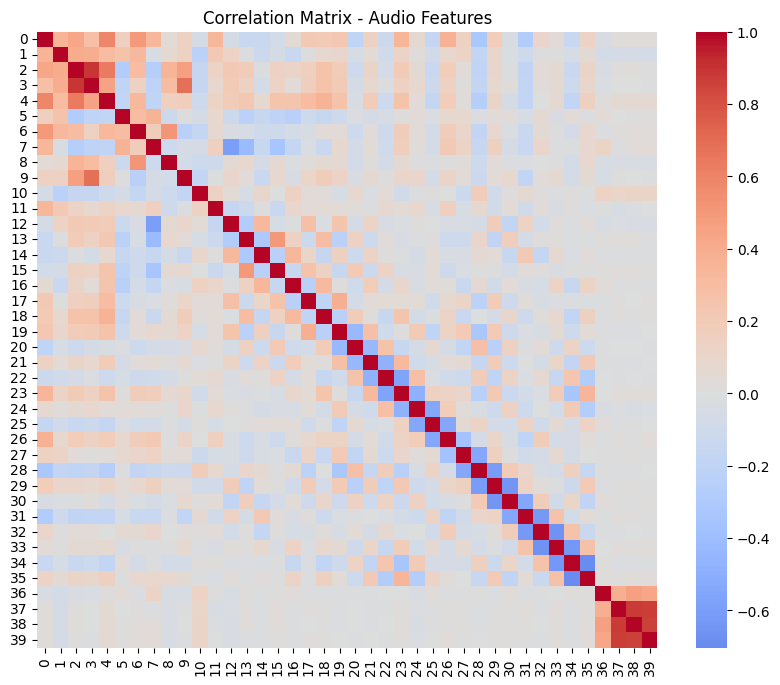

In [ ]:
df_audio = pd.DataFrame(X_audio)

plt.figure(figsize=(10, 8))
sns.heatmap(df_audio.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Matrix - Audio Features")
plt.show()


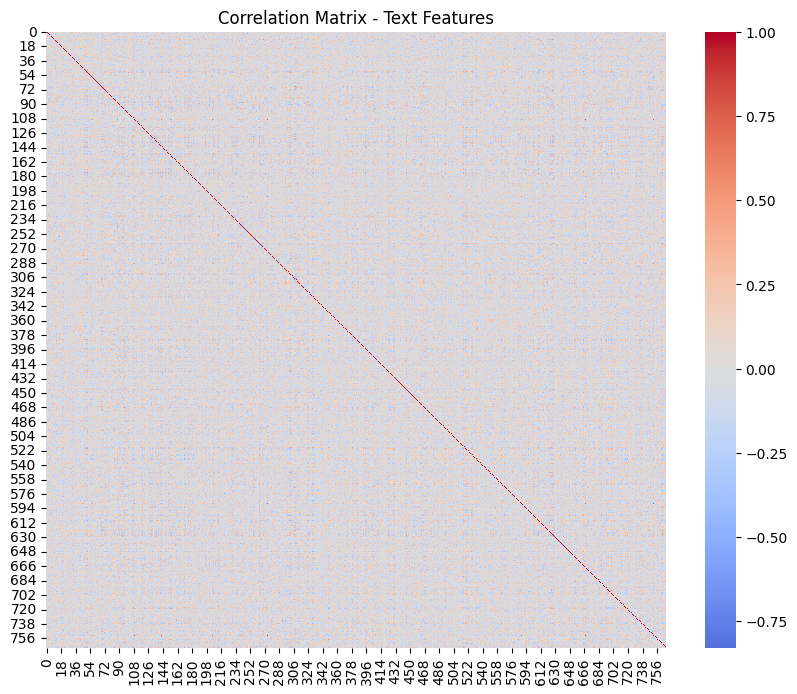

In [ ]:
df_text = pd.DataFrame(X_text)

plt.figure(figsize=(10, 8))
sns.heatmap(df_text.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Matrix - Text Features")
plt.show()


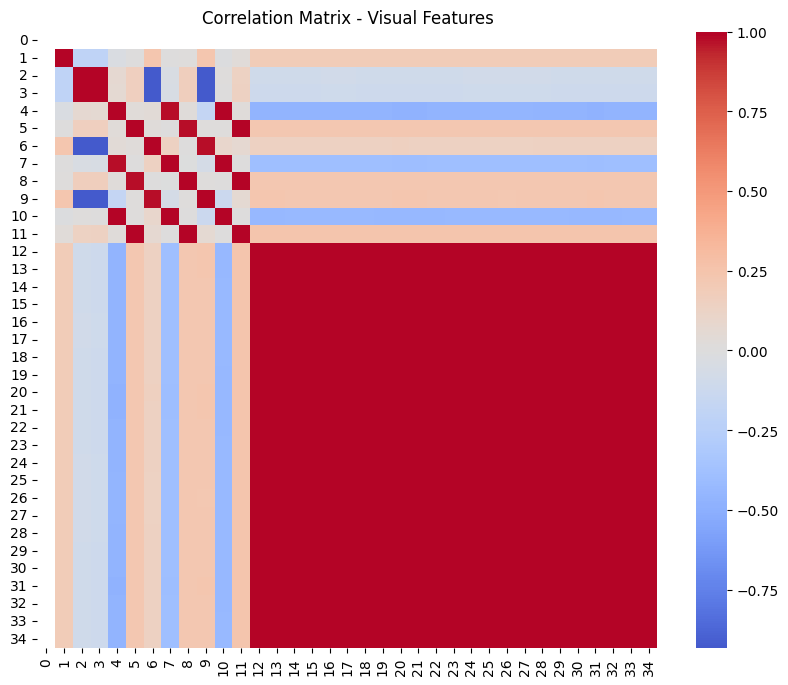

In [ ]:
df_visual = pd.DataFrame(X_visual)

plt.figure(figsize=(10, 8))
sns.heatmap(df_visual.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Matrix - Visual Features")
plt.show()


In [ ]:
for batch in test_loader:
    print("Batch type:", type(batch))
    print("Batch content:", batch)
    break

Batch type: <class 'dict'>
Batch content: {'acoustic': tensor([[1.1840e+02, 5.9162e-01, 6.2803e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.9144e+02, 7.2866e-01, 8.9589e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.8668e+02, 5.8062e-01, 8.1468e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.9407e+02, 6.7117e-01, 1.0655e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.2119e+02, 7.2512e-01, 1.0256e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.9767e+02, 6.2978e-01, 8.0046e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]]), 'visual': tensor([[  0.0000,  17.0167,   0.9800,  ..., 354.8990, 356.0960, 357.2409],
        [  0.0000,  38.5667,   0.9640,  ..., 237.2046, 238.4691, 239.7208],
        [  0.0000,  28.8000,   0.9663,  ..., 612.7575, 614.7434, 616.7589],
        ...,
        [  0.0000,  29.2167,   0.9800,  ..., 252.3540, 253.9496, 255.4945],
        [  0.0000,  5

Batch type: <class 'dict'>
Batch keys: ['acoustic', 'visual', 'language', 'label']


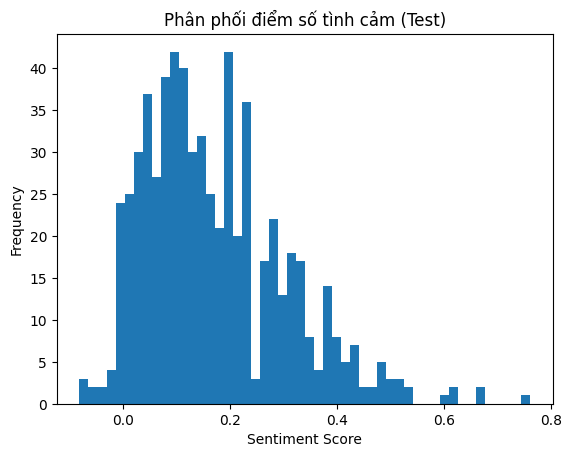

In [ ]:
if 'test_loader' not in globals():
    raise ValueError("test_loader is not defined. Ensure DataLoader is initialized.")

for batch in test_loader:
    print("Batch type:", type(batch))
    if isinstance(batch, dict):
        print("Batch keys:", list(batch.keys()))
    else:
        print("Batch length:", len(batch))
        print("Batch content:", [b.shape if isinstance(b, torch.Tensor) else type(b) for b in batch])
    break

targets = []
try:
    for batch in test_loader:
        if isinstance(batch, dict):
            targets.extend(batch["label"].numpy())
        else:
            # Multimodal: (text, audio, video, target); Unimodal: (input_data, target)
            target_idx = -1 if len(batch) > 2 else 1
            targets.extend(batch[target_idx].numpy())
except Exception as e:
    print("Error extracting targets:", e)
    raise

plt.hist(targets, bins=50)
plt.title("Phân phối điểm số tình cảm (Test)")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

In [ ]:
class CrossAttention(nn.Module):
    def __init__(self, query_dim, key_dim, value_dim, hidden_dim, num_heads=8, dropout_rate=0.1):
        super(CrossAttention, self).__init__()

        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.head_dim = hidden_dim // num_heads
        assert self.head_dim * num_heads == hidden_dim, "hidden_dim must be divisible by num_heads"

        # Linear layers to project query, key, and value to hidden dimensions
        self.query_proj = nn.Linear(query_dim, hidden_dim)
        self.key_proj = nn.Linear(key_dim, hidden_dim)
        self.value_proj = nn.Linear(value_dim, hidden_dim)

        # Output projection
        self.output_proj = nn.Linear(hidden_dim, hidden_dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, query, key, value):
        batch_size = query.size(0)

        # Project query, key, value
        query = self.query_proj(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        key = self.key_proj(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        value = self.value_proj(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Calculate attention scores
        attention_scores = torch.matmul(query, key.transpose(-2, -1))
        attention_scores = attention_scores / math.sqrt(self.head_dim)

        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # Apply attention weights to values
        attended_values = torch.matmul(attention_weights, value)

        # Reshape and project output
        attended_values = attended_values.transpose(1, 2).contiguous().view(batch_size, -1, self.hidden_dim)
        output = self.output_proj(attended_values)

        # Remove sequence dimension if only one token
        if output.size(1) == 1:
            output = output.squeeze(1)

        return output



In [ ]:
class MultimodalCrossAttention(nn.Module):
    def __init__(
        self,
        text_dim,
        audio_dim,
        visual_dim,
        hidden_dim=256,
        num_heads=8,
        dropout_rate=0.1
    ):
        super(MultimodalCrossAttention, self).__init__()

        # Project input modalities to common hidden dimension
        self.text_proj = nn.Linear(text_dim, hidden_dim)
        # self.audio_proj = nn.Linear(audio_dim, hidden_dim)
        self.visual_proj = nn.Linear(visual_dim, hidden_dim)

        # Cross-attention modules
        # Text as query, attend to audio and visual
        # self.text_audio_attn = CrossAttention(
        #     hidden_dim, hidden_dim, hidden_dim, hidden_dim, num_heads, dropout_rate
        # )
        self.text_visual_attn = CrossAttention(
            hidden_dim, hidden_dim, hidden_dim, hidden_dim, num_heads, dropout_rate
        )

        # Audio as query, attend to text and visual
        # self.audio_text_attn = CrossAttention(
        #     hidden_dim, hidden_dim, hidden_dim, hidden_dim, num_heads, dropout_rate
        # )
        # self.audio_visual_attn = CrossAttention(
        #     hidden_dim, hidden_dim, hidden_dim, hidden_dim, num_heads, dropout_rate
        # )

        # Visual as query, attend to text and audio
        self.visual_text_attn = CrossAttention(
            hidden_dim, hidden_dim, hidden_dim, hidden_dim, num_heads, dropout_rate
        )
        # self.visual_audio_attn = CrossAttention(
        #     hidden_dim, hidden_dim, hidden_dim, hidden_dim, num_heads, dropout_rate
        # )

        # Final fusion layer
        self.fusion_layer = nn.Sequential(
            # nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Output projection for sentiment prediction
        self.output_proj = nn.Linear(hidden_dim, 1)

    def forward(self, text_features, visual_features):
        batch_size = text_features.size(0)

        # Project features to the hidden dimension
        text_proj = self.text_proj(text_features)
        # audio_proj = self.audio_proj(audio_features)
        visual_proj = self.visual_proj(visual_features)

        # Add sequence dimension for attention if needed (e.g., [B, D] -> [B, 1, D])
        if len(text_proj.shape) == 2:
            text_proj = text_proj.unsqueeze(1)
            # audio_proj = audio_proj.unsqueeze(1)
            visual_proj = visual_proj.unsqueeze(1)

        # Cross-attention: text attending to other modalities
        # text_audio_attn = self.text_audio_attn(text_proj, audio_proj, audio_proj)
        text_visual_attn = self.text_visual_attn(text_proj, visual_proj, visual_proj)
        text_context = text_proj + text_visual_attn

        # Cross-attention: audio attending to other modalities
        # audio_text_attn = self.audio_text_attn(audio_proj, text_proj, text_proj)
        # audio_visual_attn = self.audio_visual_attn(audio_proj, visual_proj, visual_proj)
        # audio_context = audio_proj + audio_text_attn + audio_visual_attn

        # Cross-attention: visual attending to other modalities
        visual_text_attn = self.visual_text_attn(visual_proj, text_proj, text_proj)
        # visual_audio_attn = self.visual_audio_attn(visual_proj, audio_proj, audio_proj)
        visual_context = visual_proj + visual_text_attn
        # Remove sequence dimension ([B, 1, D] -> [B, D])
        if len(text_proj.shape) == 3:
            text_proj = text_proj.squeeze(1)
            # audio_proj = audio_proj.squeeze(1)
            visual_proj = visual_proj.squeeze(1)

        # Concatenate fused features from all modalities
        # concat_features = torch.cat([text_features,  visual_features], dim=1)
        concat_features = torch.cat([text_proj.squeeze(1), visual_proj.squeeze(1)], dim=1)

        # Apply fusion layer
        fused_features = self.fusion_layer(concat_features)

        # Predict sentiment
        sentiment = self.output_proj(fused_features)

        return fused_features, sentiment

In [ ]:
def compute_regression_accuracy(preds, labels, tolerance=0.1):
    correct = np.sum(np.abs(preds - labels) <= tolerance)
    return correct / len(labels)


In [ ]:
def evaluate_metrics(preds, labels):
    mae = mean_absolute_error(labels, preds)
    mse = mean_squared_error(labels, preds)
    if np.std(preds) == 0 or np.std(labels) == 0:
        corr = 0
    else:
        corr = np.corrcoef(preds, labels)[0, 1]
    return {"mae": mae, "mse": mse, "corr": corr}


In [ ]:
def compute_accuracy(preds, labels, tolerance=0.1):
    preds = np.array(preds)
    labels = np.array(labels)
    return np.mean(np.abs(preds - labels) <= tolerance)

In [ ]:
class AudioSentimentModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout_rate=0.3):
        super(AudioSentimentModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim // 2)

        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)

        return x

In [ ]:
def accuracy_within_tolerance(preds, labels, tolerance=0.1):
    preds = np.array(preds)
    labels = np.array(labels)
    correct = np.abs(preds - labels) <= tolerance
    return np.mean(correct)


In [ ]:
def check_nan_in_loader(loader):
    total_batches = 0
    bad_batches = 0

    for batch in loader:
        total_batches += 1

        # Bỏ qua label
        inputs = {k: v for k, v in batch.items() if k != 'label'}

        # Kiểm tra từng modality
        bad_input = False
        for modality_name, modality_tensor in inputs.items():
            if torch.isnan(modality_tensor).any() or torch.isinf(modality_tensor).any():
                print(f"Found NaN/Inf in '{modality_name}' at batch {total_batches}")
                bad_input = True
                break

        if bad_input:
            bad_batches += 1

    print(f"Total batches: {total_batches}, Batches with NaN/Inf: {bad_batches}")


In [ ]:
check_nan_in_loader(train_loader)


Found NaN/Inf in 'acoustic' at batch 1
Found NaN/Inf in 'acoustic' at batch 2
Found NaN/Inf in 'acoustic' at batch 3
Found NaN/Inf in 'acoustic' at batch 4
Found NaN/Inf in 'acoustic' at batch 5
Found NaN/Inf in 'acoustic' at batch 6
Found NaN/Inf in 'acoustic' at batch 7
Found NaN/Inf in 'acoustic' at batch 8
Found NaN/Inf in 'acoustic' at batch 9
Found NaN/Inf in 'acoustic' at batch 10
Found NaN/Inf in 'acoustic' at batch 11
Found NaN/Inf in 'acoustic' at batch 12
Found NaN/Inf in 'acoustic' at batch 13
Found NaN/Inf in 'acoustic' at batch 14
Found NaN/Inf in 'acoustic' at batch 15
Found NaN/Inf in 'acoustic' at batch 16
Found NaN/Inf in 'acoustic' at batch 17
Found NaN/Inf in 'acoustic' at batch 18
Found NaN/Inf in 'acoustic' at batch 19
Found NaN/Inf in 'acoustic' at batch 20
Found NaN/Inf in 'acoustic' at batch 21
Found NaN/Inf in 'acoustic' at batch 22
Found NaN/Inf in 'acoustic' at batch 23
Found NaN/Inf in 'acoustic' at batch 24
Found NaN/Inf in 'acoustic' at batch 25
Found NaN

In [ ]:
first_batch = next(iter(train_loader))

print("Các keys trong batch:", first_batch.keys())

print("Acoustic batch:")
print(first_batch['acoustic'])


Các keys trong batch: dict_keys(['acoustic', 'visual', 'language', 'label'])
Acoustic batch:
tensor([[1.3689e+02, 7.0723e-01, 6.8011e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.4342e+02, 4.4877e-01, 4.0883e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.1860e+02, 4.0634e-01, 4.7279e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.9968e+02, 6.1333e-01, 9.6402e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0605e+02, 8.2142e-01, 8.2641e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.1766e+02, 7.7484e-01, 7.6132e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


In [ ]:
acoustic_batch = first_batch['acoustic']
print("Có NaN?", torch.isnan(acoustic_batch).any().item())
print("Có Inf?", torch.isinf(acoustic_batch).any().item())


Có NaN? False
Có Inf? True


In [ ]:
def train_audio_model(train_loader, val_loader, input_dim, model_path='best_audio_model.pt', num_epochs=50, lr=1e-4):
    model = AudioSentimentModel(input_dim=input_dim).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0
        all_train_preds, all_train_labels = [], []

        pbar = tqdm(train_loader, desc=f"[Epoch {epoch}] Training")

        for batch in pbar:
            if isinstance(batch, dict):
                inputs = batch['acoustic'].to(DEVICE)
                labels = batch['label'].to(DEVICE)
            else:
                inputs, labels = batch
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Check for NaN/Inf in input
            if torch.isnan(inputs).any() or torch.isinf(inputs).any():
                print("Skipping batch: input contains NaN or Inf")
                continue

            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = torch.nan_to_num(outputs, nan=0.0)

            loss = criterion(outputs.squeeze(), labels)
            if torch.isnan(loss):
                print(f"Skipping batch: NaN loss at epoch {epoch}")
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            all_train_preds.extend(outputs.detach().squeeze().cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_acc = accuracy_within_tolerance(np.array(all_train_preds), np.array(all_train_labels))
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        all_val_preds, all_val_labels = [], []

        with torch.no_grad():
            for batch in val_loader:
                if isinstance(batch, dict):
                    inputs = batch['acoustic'].to(DEVICE)
                    labels = batch['label'].to(DEVICE)
                else:
                    inputs, labels = batch
                    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                outputs = model(inputs)
                outputs = torch.nan_to_num(outputs, nan=0.0)

                loss = criterion(outputs.squeeze(), labels)
                if torch.isnan(loss):
                    print(f"Skipping val batch: NaN loss at epoch {epoch}")
                    continue

                val_loss += loss.item()
                all_val_preds.extend(outputs.detach().squeeze().cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_acc = accuracy_within_tolerance(np.array(all_val_preds), np.array(all_val_labels))
        val_accuracies.append(val_acc)

        # Save model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)

        print(f"[Epoch {epoch}] Train Loss: {avg_train_loss:.4f}, Train Accuracy (±0.1): {train_acc:.4f}")
        print(f"[Epoch {epoch}] Val Loss: {avg_val_loss:.4f}, Val Accuracy (±0.1): {val_acc:.4f}")
        print(f"[Epoch {epoch}] Sample Predictions: {np.array(all_val_preds[:5]).round(4)}")
        print(f"[Epoch {epoch}] Sample Labels     : {np.array(all_val_labels[:5]).round(4)}")

    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_audio_model(train_loader, val_loader, input_dim=AUDIO_FEATURE_SIZE)



[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 1] Training: 100%|██████████| 74/74 [00:00<00:00, 671.72it/s]
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 2] Training: 100%|██████████| 74/74 [00:00<00:00, 519.82it/s]
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf




[Epoch 3] Training:  81%|████████  | 60/74 [00:00<00:00, 598.91it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

[Epoch 3] Training: 100%|██████████| 74/74 [00:00<00:00, 590.47it/s]


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 3] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 3] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 3] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 3] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 4] Training: 100%|██████████| 74/74 [00:00<00:00, 679.26it/s]


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 4] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 4] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 4] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 4] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 5] Training: 100%|██████████| 74/74 [00:00<00:00, 690.51it/s]


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 5] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 5] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoc



[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 6] Training: 100%|██████████| 74/74 [00:00<00:00, 654.80it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

[Epoch 6] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 6] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 6] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 6] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 7] Training:  95%|█████████▍| 70/74 [00:00<00:00, 691.48it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 7] Training: 100%|██████████| 74/74 [00:00<00:00, 660.04it/s]


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 7] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 7] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 7] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 7] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 8] Training: 100%|██████████| 74/74 [00:00<00:00, 631.71it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 8] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 8] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 8] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 8] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 9] Training: 100%|██████████| 74/74 [00:00<00:00, 618.94it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

[Epoch 9] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 9] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 9] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 9] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 10] Training: 100%|██████████| 74/74 [00:00<00:00, 650.38it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 10] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 10] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 10] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 10] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 11] Training:  82%|████████▏ | 61/74 [00:00<00:00, 608.83it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

[Epoch 11] Training: 100%|██████████| 74/74 [00:00<00:00, 572.22it/s]


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 11] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 11] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 11] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 11] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 12] Training:  95%|█████████▍| 70/74 [00:00<00:00, 692.99it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

[Epoch 12] Training: 100%|██████████| 74/74 [00:00<00:00, 646.95it/s]


Skipping batch: input contains NaN or Inf
[Epoch 12] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 12] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 12] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 12] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 13] Training:  78%|███████▊  | 58/74 [00:00<00:00, 579.96it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 13] Training: 100%|██████████| 74/74 [00:00<00:00, 514.63it/s]


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 13] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 13] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 13] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 13] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 14] Training:  61%|██████    | 45/74 [00:00<00:00, 439.68it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 14] Training: 100%|██████████| 74/74 [00:00<00:00, 438.05it/s]


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 14] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 14] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 14] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 14] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 15] Training:  57%|█████▋    | 42/74 [00:00<00:00, 416.40it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 15] Training: 100%|██████████| 74/74 [00:00<00:00, 369.61it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf



/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[Epoch 15] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 15] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 15] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 15] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 16] Training:  69%|██████▉   | 51/74 [00:00<00:00, 504.39it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

[Epoch 16] Training: 100%|██████████| 74/74 [00:00<00:00, 486.45it/s]


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 16] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 16] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 16] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 16] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 17] Training:  68%|██████▊   | 50/74 [00:00<00:00, 495.05it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 17] Training: 100%|██████████| 74/74 [00:00<00:00, 498.00it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 17] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 17] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 17] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 17] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 18] Training:  68%|██████▊   | 50/74 [00:00<00:00, 493.80it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 18] Training: 100%|██████████| 74/74 [00:00<00:00, 494.09it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 18] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 18] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 18] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 18] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 19] Training:  65%|██████▍   | 48/74 [00:00<00:00, 470.82it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

[Epoch 19] Training: 100%|██████████| 74/74 [00:00<00:00, 478.85it/s]


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 19] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 19] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 19] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 19] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 20] Training:  55%|█████▌    | 41/74 [00:00<00:00, 408.64it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

[Epoch 20] Training: 100%|██████████| 74/74 [00:00<00:00, 281.44it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 20] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 20] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 20] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 20] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf




[Epoch 21] Training:  15%|█▍        | 11/74 [00:00<00:00, 105.28it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf




[Epoch 21] Training:  34%|███▍      | 25/74 [00:00<00:00, 120.64it/s]

Skipping batch: input contains NaN or Inf


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf




[Epoch 21] Training:  51%|█████▏    | 38/74 [00:00<00:00, 116.76it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf




[Epoch 21] Training:  78%|███████▊  | 58/74 [00:00<00:00, 140.16it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf




[Epoch 21] Training:  97%|█████████▋| 72/74 [00:00<00:00, 118.44it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 21] Training: 100%|██████████| 74/74 [00:00<00:00, 117.77it/s]

Skipping batch: input contains NaN or Inf



/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[Epoch 21] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 21] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 21] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 21] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf




[Epoch 22] Training:  58%|█████▊    | 43/74 [00:00<00:00, 429.04it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

[Epoch 22] Training: 100%|██████████| 74/74 [00:00<00:00, 401.11it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 22] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 22] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 22] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 22] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf




[Epoch 23] Training:  39%|███▉      | 29/74 [00:00<00:00, 287.95it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 23] Training:  97%|█████████▋| 72/74 [00:00<00:00, 370.06it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 23] Training: 100%|██████████| 74/74 [00:00<00:00, 351.01it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf



/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[Epoch 23] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 23] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 23] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 23] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 24] Training:  74%|███████▍  | 55/74 [00:00<00:00, 546.49it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

[Epoch 24] Training: 100%|██████████| 74/74 [00:00<00:00, 492.83it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 24] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 24] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 24] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 24] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 25] Training: 100%|██████████| 74/74 [00:00<00:00, 613.66it/s]


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 25] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 25] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 25] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 25] Sample L



[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 26] Training: 100%|██████████| 74/74 [00:00<00:00, 582.67it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

[Epoch 26] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 26] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 26] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 26] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 27] Training:  80%|███████▉  | 59/74 [00:00<00:00, 589.85it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 27] Training: 100%|██████████| 74/74 [00:00<00:00, 547.28it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 27] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 27] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 27] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 27] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 28] Training:  59%|█████▉    | 44/74 [00:00<00:00, 439.62it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 28] Training: 100%|██████████| 74/74 [00:00<00:00, 491.43it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf



/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[Epoch 28] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 28] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 28] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 28] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 29] Training: 100%|██████████| 74/74 [00:00<00:00, 603.31it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

[Epoch 29] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 29] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 29] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 29] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 30] Training: 100%|██████████| 74/74 [00:00<00:00, 630.15it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 30] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 30] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 30] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 30] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 31] Training:  81%|████████  | 60/74 [00:00<00:00, 596.02it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

[Epoch 31] Training: 100%|██████████| 74/74 [00:00<00:00, 558.48it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 31] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 31] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 31] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 31] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 32] Training:  86%|████████▋ | 64/74 [00:00<00:00, 636.76it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

[Epoch 32] Training: 100%|██████████| 74/74 [00:00<00:00, 593.51it/s]


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 32] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 32] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 32] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 32] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

[Epoch 33] Training:  88%|████████▊ | 65/74 [00:00<00:00, 647.12it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 33] Training: 100%|██████████| 74/74 [00:00<00:00, 595.16it/s]


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 33] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 33] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 33] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 33] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 34] Training:  74%|███████▍  | 55/74 [00:00<00:00, 544.71it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 34] Training: 100%|██████████| 74/74 [00:00<00:00, 522.19it/s]


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 34] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 34] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 34] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 34] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 35] Training:  85%|████████▌ | 63/74 [00:00<00:00, 621.44it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 35] Training: 100%|██████████| 74/74 [00:00<00:00, 575.81it/s]


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 35] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 35] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 35] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 35] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 36] Training:  89%|████████▉ | 66/74 [00:00<00:00, 652.28it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf

[Epoch 36] Training: 100%|██████████| 74/74 [00:00<00:00, 597.01it/s]



Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 36] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 36] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 36] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 36] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 37] Training:  82%|████████▏ | 61/74 [00:00<00:00, 604.08it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

[Epoch 37] Training: 100%|██████████| 74/74 [00:00<00:00, 568.65it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 37] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 37] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 37] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 37] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]





[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 38] Training:  59%|█████▉    | 44/74 [00:00<00:00, 436.05it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 38] Training: 100%|██████████| 74/74 [00:00<00:00, 476.44it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

[Epoch 38] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 38] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 38] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 38] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 39] Training:  77%|███████▋  | 57/74 [00:00<00:00, 567.30it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 39] Training: 100%|██████████| 74/74 [00:00<00:00, 553.71it/s]
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 39] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 39] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 39] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 39] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 40] Training:  74%|███████▍  | 55/74 [00:00<00:00, 549.91it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 40] Training: 100%|██████████| 74/74 [00:00<00:00, 530.79it/s]


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 40] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 40] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 40] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 40] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 41] Training:  80%|███████▉  | 59/74 [00:00<00:00, 588.72it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

[Epoch 41] Training: 100%|██████████| 74/74 [00:00<00:00, 529.03it/s]
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 41] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 41] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 41] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 41] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 42] Training:  85%|████████▌ | 63/74 [00:00<00:00, 620.13it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 42] Training: 100%|██████████| 74/74 [00:00<00:00, 585.80it/s]


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 42] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 42] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 42] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 42] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 43] Training:  84%|████████▍ | 62/74 [00:00<00:00, 612.62it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 43] Training: 100%|██████████| 74/74 [00:00<00:00, 584.47it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 43] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 43] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 43] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 43] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 44] Training:  68%|██████▊   | 50/74 [00:00<00:00, 496.75it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 44] Training: 100%|██████████| 74/74 [00:00<00:00, 485.84it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 44] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 44] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 44] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 44] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 45] Training:  73%|███████▎  | 54/74 [00:00<00:00, 538.48it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 45] Training: 100%|██████████| 74/74 [00:00<00:00, 536.73it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 45] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 45] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 45] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 45] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 46] Training:  74%|███████▍  | 55/74 [00:00<00:00, 546.48it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

[Epoch 46] Training: 100%|██████████| 74/74 [00:00<00:00, 443.97it/s]
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 46] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 46] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 46] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 46] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 47] Training:  77%|███████▋  | 57/74 [00:00<00:00, 565.48it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN

[Epoch 47] Training: 100%|██████████| 74/74 [00:00<00:00, 545.73it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 47] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 47] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 47] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 47] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 48] Training:  74%|███████▍  | 55/74 [00:00<00:00, 542.45it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf

[Epoch 48] Training: 100%|██████████| 74/74 [00:00<00:00, 527.94it/s]



Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
[Epoch 48] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 48] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 48] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 48] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 49] Training:  78%|███████▊  | 58/74 [00:00<00:00, 575.48it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 49] Training: 100%|██████████| 74/74 [00:00<00:00, 580.46it/s]

Skipping batch: input contains NaN or Inf


[Epoch 49] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 49] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 49] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 49] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN



[Epoch 50] Training:  70%|███████   | 52/74 [00:00<00:00, 514.89it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 50] Training: 100%|██████████| 74/74 [00:00<00:00, 464.49it/s]

Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf
Skipping batch: input contains NaN or Inf


[Epoch 50] Train Loss: 0.0000, Train Accuracy (±0.1): nan
[Epoch 50] Val Loss: 0.5241, Val Accuracy (±0.1): 0.2461
[Epoch 50] Sample Predictions: [ 0.     0.     0.     0.    -1.304]
[Epoch 50] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]


In [ ]:
class TextSentimentModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout_rate=0.3):
        super(TextSentimentModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)

        self.dropout = nn.Dropout(dropout_rate)
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim)
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim // 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x

In [ ]:
def train_text_model(train_loader, val_loader, input_dim, model_path=None, num_epochs=50, lr=1e-4):
    model = TextSentimentModel(input_dim=input_dim).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0
        all_train_preds = []
        all_train_labels = []

        pbar = tqdm(train_loader, desc=f"[Epoch {epoch}] Training")
        for batch in pbar:
            if isinstance(batch, dict):
                inputs = batch["language"].to(DEVICE)
                labels = batch["label"].to(DEVICE)
            else:
                inputs, labels = batch
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.squeeze()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            all_train_preds.extend(outputs.detach().cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
        pbar.close()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = compute_accuracy(all_train_preds, all_train_labels)

        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for batch in val_loader:
                if isinstance(batch, dict):
                    inputs = batch["language"].to(DEVICE)
                    labels = batch["label"].to(DEVICE)
                else:
                    inputs, labels = batch
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)

                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                all_val_preds.extend(outputs.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = compute_accuracy(all_val_preds, all_val_labels)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"[Epoch {epoch}] Train Loss: {avg_train_loss:.4f}, Train Accuracy (±0.1): {train_acc:.4f}")
        print(f"[Epoch {epoch}] Val Loss: {avg_val_loss:.4f}, Val Accuracy (±0.1): {val_acc:.4f}")
        print(f"[Epoch {epoch}] Predictions: {np.round(all_val_preds[:5], 4)}")
        print(f"[Epoch {epoch}] Labels     : {np.round(all_val_labels[:5], 4)}")

        if model_path is not None:
            torch.save(model.state_dict(), model_path)

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-o', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-o', label='Val Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-o', label='Train Accuracy (±0.1)')
    plt.plot(epochs, val_accuracies, 'r-o', label='Val Accuracy (±0.1)')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
model, train_losses, val_losses, train_accuracies, val_accuracie = train_text_model(train_loader, val_loader, input_dim = TEXT_EMBEDDING_DIM)



[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.3212]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.2691]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1870]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1830]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1731]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.2866]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.2337]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1828]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1809]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1855]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1845]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1646]

[Epoch 1] Training:  16%|█▌        | 12/74 [00:00<00:00, 117.8

[Epoch 1] Train Loss: 0.1637, Train Accuracy (±0.1): 0.1985
[Epoch 1] Val Loss: 0.0407, Val Accuracy (±0.1): 0.3984
[Epoch 1] Predictions: [0.1647 0.1489 0.1412 0.3504 0.3943]
[Epoch 1] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1351]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1691]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1679]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0979]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1590]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.2025]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0976]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1681]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1233]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1168]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.2183]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1039]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, los

[Epoch 2] Train Loss: 0.1221, Train Accuracy (±0.1): 0.2344
[Epoch 2] Val Loss: 0.0375, Val Accuracy (±0.1): 0.4102
[Epoch 2] Predictions: [ 0.0973  0.154  -0.004   0.3013  0.2413]
[Epoch 2] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0828]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1183]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1011]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1003]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1066]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1418]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1478]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1503]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1011]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1042]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1160]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0761]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, los

[Epoch 3] Train Loss: 0.1022, Train Accuracy (±0.1): 0.2568
[Epoch 3] Val Loss: 0.0322, Val Accuracy (±0.1): 0.4414
[Epoch 3] Predictions: [0.1978 0.1734 0.1625 0.2167 0.4661]
[Epoch 3] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0623]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1175]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0730]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0906]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0818]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0651]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0779]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0988]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0923]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1044]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1190]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0947]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, los

[Epoch 4] Train Loss: 0.0851, Train Accuracy (±0.1): 0.2707
[Epoch 4] Val Loss: 0.0311, Val Accuracy (±0.1): 0.4492
[Epoch 4] Predictions: [0.1042 0.2206 0.124  0.2131 0.4478]
[Epoch 4] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0670]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0829]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0799]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0711]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0757]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1135]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1397]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0500]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0634]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0537]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0642]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0883]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, los

[Epoch 5] Train Loss: 0.0757, Train Accuracy (±0.1): 0.2965
[Epoch 5] Val Loss: 0.0289, Val Accuracy (±0.1): 0.4453
[Epoch 5] Predictions: [0.0776 0.1996 0.1467 0.1792 0.4244]
[Epoch 5] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0622]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0533]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0915]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0521]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0795]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0760]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0543]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0665]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0523]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0815]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0710]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0922]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, los

[Epoch 6] Train Loss: 0.0707, Train Accuracy (±0.1): 0.3087
[Epoch 6] Val Loss: 0.0258, Val Accuracy (±0.1): 0.5078
[Epoch 6] Predictions: [-0.0183  0.1502  0.1249  0.2314  0.3684]
[Epoch 6] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0682]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0744]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0660]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0518]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0642]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0821]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0630]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0648]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0977]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0538]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0441]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.1073]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, los

[Epoch 7] Train Loss: 0.0660, Train Accuracy (±0.1): 0.3184
[Epoch 7] Val Loss: 0.0252, Val Accuracy (±0.1): 0.4922
[Epoch 7] Predictions: [0.0073 0.2349 0.0703 0.1404 0.307 ]
[Epoch 7] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0653]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0433]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0506]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0503]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0580]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0932]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0504]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0307]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0418]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0730]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0412]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0366]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, los

[Epoch 8] Train Loss: 0.0601, Train Accuracy (±0.1): 0.3197
[Epoch 8] Val Loss: 0.0237, Val Accuracy (±0.1): 0.5273
[Epoch 8] Predictions: [0.039  0.1364 0.0871 0.1737 0.2834]
[Epoch 8] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0594]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0553]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0620]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0586]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0495]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0560]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0802]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0664]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0530]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0529]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0682]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0440]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, los

[Epoch 9] Train Loss: 0.0517, Train Accuracy (±0.1): 0.3412
[Epoch 9] Val Loss: 0.0207, Val Accuracy (±0.1): 0.5273
[Epoch 9] Predictions: [0.0153 0.1789 0.1239 0.1548 0.2822]
[Epoch 9] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0663]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0534]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0532]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0412]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0565]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0509]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0555]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0428]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0339]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0345]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0416]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0607]

[Epoch 10] Training:  16%|█▌        | 12/74 [00:0

[Epoch 10] Train Loss: 0.0473, Train Accuracy (±0.1): 0.3590
[Epoch 10] Val Loss: 0.0234, Val Accuracy (±0.1): 0.5234
[Epoch 10] Predictions: [-0.0187  0.1886  0.064   0.1364  0.2278]
[Epoch 10] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0695]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0318]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0487]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0460]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0509]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0384]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0488]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0470]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0446]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0708]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0319]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0496]

[Epoch 11] Training:  16%|█▌        | 12/74 [00:0

[Epoch 11] Train Loss: 0.0461, Train Accuracy (±0.1): 0.3699
[Epoch 11] Val Loss: 0.0208, Val Accuracy (±0.1): 0.5977
[Epoch 11] Predictions: [0.0165 0.2199 0.1434 0.1827 0.2725]
[Epoch 11] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0479]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0447]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0458]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0432]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0406]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0645]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0384]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0318]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0457]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0380]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0409]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0397]

[Epoch 12] Training:   0%|          | 0/74 [00:00

[Epoch 12] Train Loss: 0.0402, Train Accuracy (±0.1): 0.3915
[Epoch 12] Val Loss: 0.0206, Val Accuracy (±0.1): 0.5625
[Epoch 12] Predictions: [0.0295 0.1765 0.1573 0.1345 0.328 ]
[Epoch 12] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0317]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0485]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0455]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0405]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0219]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0494]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0445]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0368]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0496]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0515]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0297]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0199]

[Epoch 13] Training:   0%|          | 0/74 [00:00

[Epoch 13] Train Loss: 0.0381, Train Accuracy (±0.1): 0.3953
[Epoch 13] Val Loss: 0.0194, Val Accuracy (±0.1): 0.5742
[Epoch 13] Predictions: [0.0267 0.1288 0.1136 0.1403 0.3012]
[Epoch 13] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0393]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0424]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0449]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0408]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0466]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0296]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0399]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0273]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0259]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0360]

[Epoch 14] Training:  14%|█▎        | 10/74 [00:00<00:00, 88.49it/s, loss=0.0360]

[Epoch 14] Training:  14%|█▎        | 10/74 [00:00<00:00, 88.49it/s, loss=0.0260]

[Epoch 14] Training:  14%|█▎   

[Epoch 14] Train Loss: 0.0346, Train Accuracy (±0.1): 0.4244
[Epoch 14] Val Loss: 0.0194, Val Accuracy (±0.1): 0.5898
[Epoch 14] Predictions: [0.0796 0.1101 0.1512 0.1397 0.2974]
[Epoch 14] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0316]

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0521]

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0295]

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0412]

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0388]

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0248]

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0364]

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0221]

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0258]

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0208]

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0282]

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0314]

[Epoch 15] Training:   0%|          | 0/74 [00:00

[Epoch 15] Train Loss: 0.0335, Train Accuracy (±0.1): 0.4088
[Epoch 15] Val Loss: 0.0187, Val Accuracy (±0.1): 0.6055
[Epoch 15] Predictions: [0.0285 0.1502 0.0822 0.1351 0.2614]
[Epoch 15] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0436]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0265]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0319]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0187]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0396]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0305]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0210]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0367]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0260]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0381]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0444]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0601]

[Epoch 16] Training:   0%|          | 0/74 [00:00

[Epoch 16] Train Loss: 0.0303, Train Accuracy (±0.1): 0.4417
[Epoch 16] Val Loss: 0.0189, Val Accuracy (±0.1): 0.5977
[Epoch 16] Predictions: [0.0127 0.0942 0.0461 0.1388 0.2523]
[Epoch 16] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0274]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0265]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0262]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0273]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0320]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0218]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0347]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0236]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0204]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0346]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0185]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0348]

[Epoch 17] Training:  16%|█▌        | 12/74 [00:0

[Epoch 17] Train Loss: 0.0286, Train Accuracy (±0.1): 0.4709
[Epoch 17] Val Loss: 0.0179, Val Accuracy (±0.1): 0.6328
[Epoch 17] Predictions: [0.0251 0.1283 0.1093 0.1313 0.3063]
[Epoch 17] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0256]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0416]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0252]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0228]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0222]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0271]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0281]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0161]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0185]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0187]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0282]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0251]

[Epoch 18] Training:   0%|          | 0/74 [00:00

[Epoch 18] Train Loss: 0.0278, Train Accuracy (±0.1): 0.4658
[Epoch 18] Val Loss: 0.0177, Val Accuracy (±0.1): 0.6133
[Epoch 18] Predictions: [0.0311 0.1443 0.1285 0.1492 0.2811]
[Epoch 18] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0285]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0314]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0162]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0094]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0224]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0196]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0414]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0164]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0394]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0321]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0344]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0198]

[Epoch 19] Training:  16%|█▌        | 12/74 [00:0

[Epoch 19] Train Loss: 0.0266, Train Accuracy (±0.1): 0.4776
[Epoch 19] Val Loss: 0.0175, Val Accuracy (±0.1): 0.6172
[Epoch 19] Predictions: [0.0335 0.1201 0.1157 0.1506 0.2765]
[Epoch 19] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0230]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0219]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0217]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0322]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0280]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0254]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0285]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0144]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0202]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0237]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0275]

[Epoch 20] Training:  15%|█▍        | 11/74 [00:00<00:00, 109.17it/s, loss=0.0275]

[Epoch 20] Training:  15%|█▍        | 1

[Epoch 20] Train Loss: 0.0238, Train Accuracy (±0.1): 0.4856
[Epoch 20] Val Loss: 0.0174, Val Accuracy (±0.1): 0.6211
[Epoch 20] Predictions: [0.038  0.155  0.1207 0.141  0.2431]
[Epoch 20] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0175]

[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0292]

[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0213]

[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0209]

[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0242]

[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0202]

[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0265]

[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0319]

[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0146]

[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0234]

[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0202]

[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0263]

[Epoch 21] Training:   0%|          | 0/74 [00:00

[Epoch 21] Train Loss: 0.0214, Train Accuracy (±0.1): 0.5228
[Epoch 21] Val Loss: 0.0166, Val Accuracy (±0.1): 0.6367
[Epoch 21] Predictions: [0.0533 0.1646 0.1628 0.1391 0.2822]
[Epoch 21] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0231]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0181]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0259]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0229]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0169]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0169]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0151]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0150]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0207]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0188]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0162]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0245]

[Epoch 22] Training:   0%|          | 0/74 [00:00

[Epoch 22] Train Loss: 0.0205, Train Accuracy (±0.1): 0.5253
[Epoch 22] Val Loss: 0.0181, Val Accuracy (±0.1): 0.6094
[Epoch 22] Predictions: [0.0492 0.1411 0.1177 0.1254 0.2439]
[Epoch 22] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0202]

[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0344]

[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0325]

[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0194]

[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0249]

[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0144]

[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0167]

[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0116]

[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0170]

[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0145]

[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0182]

[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0210]

[Epoch 23] Training:  16%|█▌        | 12/74 [00:0

[Epoch 23] Train Loss: 0.0205, Train Accuracy (±0.1): 0.5321
[Epoch 23] Val Loss: 0.0177, Val Accuracy (±0.1): 0.6133
[Epoch 23] Predictions: [0.0609 0.1402 0.1551 0.1198 0.2495]
[Epoch 23] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0144]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0165]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0192]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0265]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0150]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0204]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0273]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0219]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0108]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0162]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0321]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0133]

[Epoch 24] Training:   0%|          | 0/74 [00:00

[Epoch 24] Train Loss: 0.0192, Train Accuracy (±0.1): 0.5363
[Epoch 24] Val Loss: 0.0167, Val Accuracy (±0.1): 0.6445
[Epoch 24] Predictions: [0.0806 0.1518 0.1655 0.136  0.2475]
[Epoch 24] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0158]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0247]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0191]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0259]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0186]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0177]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0301]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0214]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0202]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0151]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0208]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0152]

[Epoch 25] Training:   0%|          | 0/74 [00:00

[Epoch 25] Train Loss: 0.0186, Train Accuracy (±0.1): 0.5541
[Epoch 25] Val Loss: 0.0169, Val Accuracy (±0.1): 0.6328
[Epoch 25] Predictions: [0.0712 0.1494 0.1411 0.1011 0.2604]
[Epoch 25] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0209]

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0178]

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0254]

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0214]

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0177]

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0180]

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0244]

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0188]

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0205]

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0177]

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0140]

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0184]

[Epoch 26] Training:   0%|          | 0/74 [00:00

[Epoch 26] Train Loss: 0.0168, Train Accuracy (±0.1): 0.5646
[Epoch 26] Val Loss: 0.0160, Val Accuracy (±0.1): 0.6367
[Epoch 26] Predictions: [0.0854 0.1397 0.1419 0.124  0.2529]
[Epoch 26] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0095]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0157]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0170]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0156]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0197]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0186]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0095]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0160]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0173]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0113]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0180]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0226]

[Epoch 27] Training:   0%|          | 0/74 [00:00

[Epoch 27] Train Loss: 0.0170, Train Accuracy (±0.1): 0.5655
[Epoch 27] Val Loss: 0.0169, Val Accuracy (±0.1): 0.6289
[Epoch 27] Predictions: [0.1003 0.134  0.1416 0.1362 0.2288]
[Epoch 27] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0146]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0177]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0112]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0091]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0097]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0154]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0114]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0084]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0166]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0199]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0288]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0180]

[Epoch 28] Training:   0%|          | 0/74 [00:00

[Epoch 28] Train Loss: 0.0154, Train Accuracy (±0.1): 0.5971
[Epoch 28] Val Loss: 0.0158, Val Accuracy (±0.1): 0.6445
[Epoch 28] Predictions: [0.0897 0.15   0.144  0.1381 0.2289]
[Epoch 28] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0071]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0109]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0206]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0179]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0131]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0141]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0118]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0184]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0141]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0128]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0168]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0139]

[Epoch 29] Training:   0%|          | 0/74 [00:00

[Epoch 29] Train Loss: 0.0155, Train Accuracy (±0.1): 0.5845
[Epoch 29] Val Loss: 0.0171, Val Accuracy (±0.1): 0.6367
[Epoch 29] Predictions: [0.0696 0.1312 0.1548 0.1123 0.2301]
[Epoch 29] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0176]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0175]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0102]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0091]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0161]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0085]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0148]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0116]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0139]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0189]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0189]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0128]

[Epoch 30] Training:   0%|          | 0/74 [00:00

[Epoch 30] Train Loss: 0.0151, Train Accuracy (±0.1): 0.6098
[Epoch 30] Val Loss: 0.0162, Val Accuracy (±0.1): 0.6328
[Epoch 30] Predictions: [0.0707 0.1411 0.1636 0.126  0.2461]
[Epoch 30] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0124]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0126]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0140]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0135]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0254]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0112]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0093]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0113]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0123]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0134]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0204]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0112]

[Epoch 31] Training:   0%|          | 0/74 [00:00

[Epoch 31] Train Loss: 0.0150, Train Accuracy (±0.1): 0.6212
[Epoch 31] Val Loss: 0.0164, Val Accuracy (±0.1): 0.6484
[Epoch 31] Predictions: [0.096  0.149  0.1677 0.1337 0.2181]
[Epoch 31] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0137]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0143]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0128]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0101]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0078]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0150]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0129]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0091]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0144]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0123]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0164]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0097]

[Epoch 32] Training:   0%|          | 0/74 [00:00

[Epoch 32] Train Loss: 0.0144, Train Accuracy (±0.1): 0.6195
[Epoch 32] Val Loss: 0.0166, Val Accuracy (±0.1): 0.6484
[Epoch 32] Predictions: [0.0925 0.1356 0.1661 0.1433 0.2183]
[Epoch 32] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0097]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0151]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0197]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0155]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0081]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0227]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0103]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0117]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0102]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0206]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0170]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0127]

[Epoch 33] Training:   0%|          | 0/74 [00:00

[Epoch 33] Train Loss: 0.0135, Train Accuracy (±0.1): 0.6427
[Epoch 33] Val Loss: 0.0160, Val Accuracy (±0.1): 0.6484
[Epoch 33] Predictions: [0.1065 0.1314 0.168  0.142  0.2287]
[Epoch 33] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0123]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0135]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0158]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0150]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0138]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0231]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0156]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0173]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0164]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0112]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0132]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0104]

[Epoch 34] Training:   0%|          | 0/74 [00:00

[Epoch 34] Train Loss: 0.0128, Train Accuracy (±0.1): 0.6381
[Epoch 34] Val Loss: 0.0151, Val Accuracy (±0.1): 0.6758
[Epoch 34] Predictions: [0.1086 0.1417 0.1835 0.143  0.2289]
[Epoch 34] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0095]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0181]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0118]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0104]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0131]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0116]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0151]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0097]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0115]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0157]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0075]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0129]

[Epoch 35] Training:  16%|█▌        | 12/74 [00:0

[Epoch 35] Train Loss: 0.0136, Train Accuracy (±0.1): 0.6318
[Epoch 35] Val Loss: 0.0155, Val Accuracy (±0.1): 0.6719
[Epoch 35] Predictions: [0.1013 0.1404 0.1814 0.1458 0.222 ]
[Epoch 35] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0139]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0083]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0128]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0097]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0146]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0084]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0115]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0068]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0073]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0105]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0100]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0179]

[Epoch 36] Training:   0%|          | 0/74 [00:00

[Epoch 36] Train Loss: 0.0126, Train Accuracy (±0.1): 0.6554
[Epoch 36] Val Loss: 0.0152, Val Accuracy (±0.1): 0.6680
[Epoch 36] Predictions: [0.1086 0.142  0.1891 0.1374 0.2415]
[Epoch 36] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0127]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0080]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0147]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0158]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0111]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0100]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0102]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0142]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0119]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0145]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0081]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0104]

[Epoch 37] Training:   0%|          | 0/74 [00:00

[Epoch 37] Train Loss: 0.0120, Train Accuracy (±0.1): 0.6655
[Epoch 37] Val Loss: 0.0148, Val Accuracy (±0.1): 0.6680
[Epoch 37] Predictions: [0.0868 0.1431 0.1706 0.135  0.2302]
[Epoch 37] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0183]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0081]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0125]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0105]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0182]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0119]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0138]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0116]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0098]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0075]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0099]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0124]

[Epoch 38] Training:   0%|          | 0/74 [00:00

[Epoch 38] Train Loss: 0.0124, Train Accuracy (±0.1): 0.6461
[Epoch 38] Val Loss: 0.0154, Val Accuracy (±0.1): 0.6602
[Epoch 38] Predictions: [0.0938 0.1303 0.1655 0.1388 0.2272]
[Epoch 38] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0098]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0188]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0076]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0151]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0084]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0123]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0120]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0074]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0141]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0080]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0101]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0089]

[Epoch 39] Training:   0%|          | 0/74 [00:00

[Epoch 39] Train Loss: 0.0114, Train Accuracy (±0.1): 0.6820
[Epoch 39] Val Loss: 0.0152, Val Accuracy (±0.1): 0.6641
[Epoch 39] Predictions: [0.112  0.1504 0.1844 0.1484 0.2421]
[Epoch 39] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0068]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0096]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0135]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0135]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0187]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0088]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0168]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0093]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0157]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0112]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0069]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0166]

[Epoch 40] Training:  16%|█▌        | 12/74 [00:0

[Epoch 40] Train Loss: 0.0116, Train Accuracy (±0.1): 0.6748
[Epoch 40] Val Loss: 0.0153, Val Accuracy (±0.1): 0.6602
[Epoch 40] Predictions: [0.112  0.1416 0.1748 0.1471 0.2275]
[Epoch 40] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0090]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0096]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0138]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0126]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0111]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0145]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0106]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0118]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0169]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0131]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0186]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0108]

[Epoch 41] Training:  16%|█▌        | 12/74 [00:0

[Epoch 41] Train Loss: 0.0112, Train Accuracy (±0.1): 0.6778
[Epoch 41] Val Loss: 0.0153, Val Accuracy (±0.1): 0.6680
[Epoch 41] Predictions: [0.1049 0.134  0.1635 0.1425 0.2124]
[Epoch 41] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0060]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0080]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0094]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0078]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0123]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0082]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0068]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0130]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0130]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0106]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0118]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0150]

[Epoch 42] Training:  16%|█▌        | 12/74 [00:0

[Epoch 42] Train Loss: 0.0106, Train Accuracy (±0.1): 0.6930
[Epoch 42] Val Loss: 0.0159, Val Accuracy (±0.1): 0.6641
[Epoch 42] Predictions: [0.1156 0.1422 0.1759 0.1461 0.2034]
[Epoch 42] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0110]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0122]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0115]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0080]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0097]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0118]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0071]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0086]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0100]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0121]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0098]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0124]

[Epoch 43] Training:   0%|          | 0/74 [00:00

[Epoch 43] Train Loss: 0.0104, Train Accuracy (±0.1): 0.7010
[Epoch 43] Val Loss: 0.0152, Val Accuracy (±0.1): 0.6758
[Epoch 43] Predictions: [0.1169 0.1626 0.1804 0.1447 0.2104]
[Epoch 43] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0059]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0061]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0066]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0134]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0075]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0058]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0066]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0115]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0120]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0187]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0092]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0122]

[Epoch 44] Training:  16%|█▌        | 12/74 [00:0

[Epoch 44] Train Loss: 0.0107, Train Accuracy (±0.1): 0.6850
[Epoch 44] Val Loss: 0.0160, Val Accuracy (±0.1): 0.6641
[Epoch 44] Predictions: [0.1169 0.1335 0.1727 0.1338 0.196 ]
[Epoch 44] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0102]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0124]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0124]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0122]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0093]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0136]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0095]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0177]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0114]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0112]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0089]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0074]

[Epoch 45] Training:   0%|          | 0/74 [00:00

[Epoch 45] Train Loss: 0.0103, Train Accuracy (±0.1): 0.7133
[Epoch 45] Val Loss: 0.0151, Val Accuracy (±0.1): 0.6680
[Epoch 45] Predictions: [0.1371 0.1382 0.1897 0.1472 0.2078]
[Epoch 45] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0077]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0134]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0114]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0082]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0097]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0081]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0116]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0104]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0083]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0073]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0067]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0087]

[Epoch 46] Training:   0%|          | 0/74 [00:00

[Epoch 46] Train Loss: 0.0098, Train Accuracy (±0.1): 0.7078
[Epoch 46] Val Loss: 0.0147, Val Accuracy (±0.1): 0.6758
[Epoch 46] Predictions: [0.1225 0.1396 0.1879 0.1527 0.2024]
[Epoch 46] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0084]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0091]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0152]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0078]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0106]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0160]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0080]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0078]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0061]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0099]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0095]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0090]

[Epoch 47] Training:  16%|█▌        | 12/74 [00:0

[Epoch 47] Train Loss: 0.0100, Train Accuracy (±0.1): 0.7086
[Epoch 47] Val Loss: 0.0158, Val Accuracy (±0.1): 0.6641
[Epoch 47] Predictions: [0.1133 0.1252 0.1791 0.1353 0.1984]
[Epoch 47] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0113]

[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0138]

[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0098]

[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0083]

[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0087]

[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0112]

[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0074]

[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0082]

[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0167]

[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0115]

[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0062]

[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0101]

[Epoch 48] Training:  16%|█▌        | 12/74 [00:0

[Epoch 48] Train Loss: 0.0096, Train Accuracy (±0.1): 0.7171
[Epoch 48] Val Loss: 0.0155, Val Accuracy (±0.1): 0.6562
[Epoch 48] Predictions: [0.1174 0.1413 0.2043 0.1387 0.2137]
[Epoch 48] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0109]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0112]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0059]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0074]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0097]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0101]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0091]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0116]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0139]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0097]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0046]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0089]

[Epoch 49] Training:   0%|          | 0/74 [00:00

[Epoch 49] Train Loss: 0.0093, Train Accuracy (±0.1): 0.7209
[Epoch 49] Val Loss: 0.0152, Val Accuracy (±0.1): 0.6719
[Epoch 49] Predictions: [0.1108 0.1475 0.1957 0.148  0.2115]
[Epoch 49] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0079]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0077]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0067]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0172]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0109]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0107]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0090]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0094]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0160]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0123]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0100]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0083]

[Epoch 50] Training:   0%|          | 0/74 [00:00

[Epoch 50] Train Loss: 0.0089, Train Accuracy (±0.1): 0.7352
[Epoch 50] Val Loss: 0.0164, Val Accuracy (±0.1): 0.6328
[Epoch 50] Predictions: [0.1045 0.1442 0.1944 0.1405 0.2001]
[Epoch 50] Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]


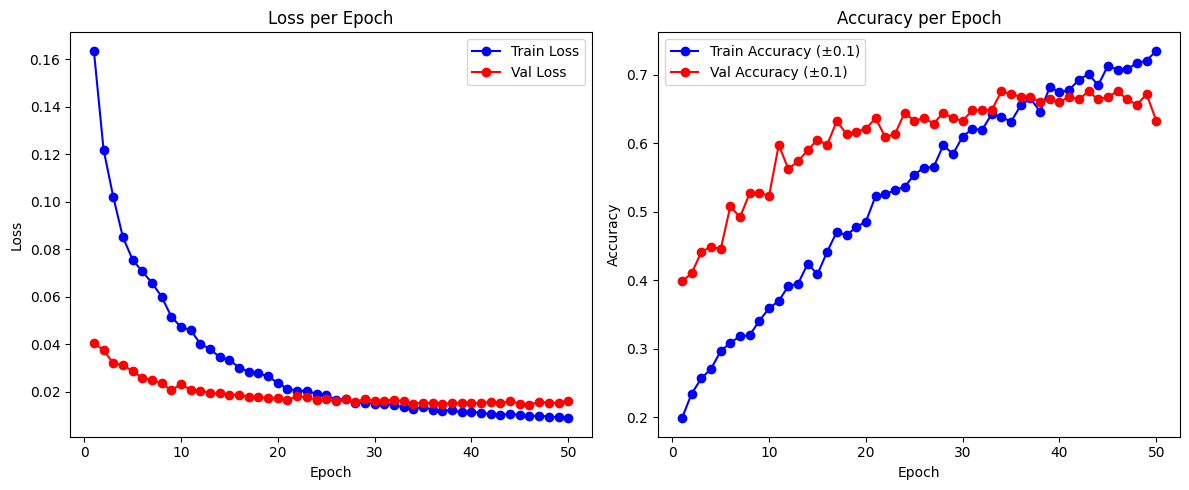

In [ ]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracie)

In [ ]:
class VisualSentimentModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout_rate=0.3):
        super(VisualSentimentModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)

        self.dropout = nn.Dropout(dropout_rate)
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim)
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim // 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x

In [ ]:
def train_visual_model(train_loader, val_loader, input_dim, model_path='visual_model.pt', num_epochs=50, lr=1e-3):
    model = VisualSentimentModel(input_dim).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0
        all_preds, all_labels = [], []

        pbar = tqdm(train_loader, desc=f"[Epoch {epoch}] Training")
        for batch in pbar:
            inputs = batch["visual"].to(DEVICE)
            labels = batch["label"].to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            all_preds.extend(outputs.squeeze().detach().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            pbar.set_postfix({"loss": loss.item()})

        avg_train_loss = epoch_loss / len(train_loader)
        train_acc = accuracy_within_tolerance(all_preds, all_labels)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch["visual"].to(DEVICE)
                labels = batch["label"].to(DEVICE)

                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()

                all_preds.extend(outputs.squeeze().cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_within_tolerance(all_preds, all_labels)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f"[Epoch {epoch}] Train Loss: {avg_train_loss:.4f}, Train Accuracy (±0.1): {train_acc:.4f}")
        print(f"[Epoch {epoch}] Val Loss: {avg_val_loss:.4f}, Val Accuracy (±0.1): {val_acc:.4f}")
        print(f"[Epoch {epoch}] Sample Predictions: {np.round(all_preds[:5], 4)}")
        print(f"[Epoch {epoch}] Sample Labels     : {np.round(all_labels[:5], 4)}")

    torch.save(model.state_dict(), model_path)
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_visual_model(train_loader, val_loader, input_dim=VISUAL_FEATURE_SIZE)



[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.116]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.159]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.238]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.212]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.201]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.207]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.115]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.141]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0955]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.161] 

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0822]

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.101] 

[Epoch 1] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.273]

[Epoch 1] Train Loss: 0.0986, Train Accuracy (±0.1): 0.3062
[Epoch 1] Val Loss: 0.0362, Val Accuracy (±0.1): 0.5000
[Epoch 1] Sample Predictions: [-0.0791  0.0812  0.0792  0.0818  0.068 ]
[Epoch 1] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0503]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0542]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0659]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0887]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0457]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0546]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0616]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0517]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.07]  

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0622]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0537]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0624]

[Epoch 2] Training:   0%|          | 0/74 [00:00<?, ?it/s, los

[Epoch 2] Train Loss: 0.0486, Train Accuracy (±0.1): 0.3851
[Epoch 2] Val Loss: 0.0187, Val Accuracy (±0.1): 0.5508
[Epoch 2] Sample Predictions: [0.2063 0.1481 0.1434 0.2049 0.2093]
[Epoch 2] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0348]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0582]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0346]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0469]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0477]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0259]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0392]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0447]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0372]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0361]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0591]

[Epoch 3] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0371]

[Epoch 3] Training:  16%|█▌        | 12/74 [00:00<00:00, 118.0

[Epoch 3] Train Loss: 0.0358, Train Accuracy (±0.1): 0.4219
[Epoch 3] Val Loss: 0.0241, Val Accuracy (±0.1): 0.5781
[Epoch 3] Sample Predictions: [-0.0146  0.1294  0.1255  0.154   0.1504]
[Epoch 3] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0209]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0335]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0333]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0405]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0204]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0345]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0304]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0213]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0162]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0269]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0261]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0342]

[Epoch 4] Training:   0%|          | 0/74 [00:00<?, ?it/s, los

[Epoch 4] Train Loss: 0.0280, Train Accuracy (±0.1): 0.4721
[Epoch 4] Val Loss: 0.0190, Val Accuracy (±0.1): 0.5312
[Epoch 4] Sample Predictions: [0.1954 0.161  0.1561 0.195  0.1977]
[Epoch 4] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0282]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0213]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0159]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0233]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0225]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0159]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0254]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0394]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0356]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0347]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0372]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0226]

[Epoch 5] Training:   0%|          | 0/74 [00:00<?, ?it/s, los

[Epoch 5] Train Loss: 0.0246, Train Accuracy (±0.1): 0.4945
[Epoch 5] Val Loss: 0.0190, Val Accuracy (±0.1): 0.5195
[Epoch 5] Sample Predictions: [0.2439 0.1802 0.1711 0.1885 0.195 ]
[Epoch 5] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.035]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0226]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0175]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0203]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0227]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0209]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0379]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.025] 

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0206]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0256]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.022] 

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0269]

[Epoch 6] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss

[Epoch 6] Train Loss: 0.0225, Train Accuracy (±0.1): 0.5215
[Epoch 6] Val Loss: 0.0191, Val Accuracy (±0.1): 0.5469
[Epoch 6] Sample Predictions: [0.1814 0.1738 0.1633 0.1754 0.1796]
[Epoch 6] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0133]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0275]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0211]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.02]  

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0192]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.02]  

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0146]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0238]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0269]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0227]

[Epoch 7] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0239]

[Epoch 7] Training:  15%|█▍        | 11/74 [00:00<00:00, 106.47it/s, loss=0.0239]

[Epoch 7] Training:  15%|█▍        | 11/74 [00:00<00

[Epoch 7] Train Loss: 0.0212, Train Accuracy (±0.1): 0.5220
[Epoch 7] Val Loss: 0.0188, Val Accuracy (±0.1): 0.5508
[Epoch 7] Sample Predictions: [0.2072 0.1566 0.1554 0.1881 0.1921]
[Epoch 7] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0303]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0167]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0159]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0147]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0294]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0156]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0225]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0271]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0214]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0169]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0181]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0168]

[Epoch 8] Training:   0%|          | 0/74 [00:00<?, ?it/s, los

[Epoch 8] Train Loss: 0.0204, Train Accuracy (±0.1): 0.5334
[Epoch 8] Val Loss: 0.0189, Val Accuracy (±0.1): 0.5586
[Epoch 8] Sample Predictions: [0.1725 0.1522 0.1551 0.1875 0.1912]
[Epoch 8] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0233]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0177]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0126]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0193]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0119]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0161]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0225]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0174]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0177]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.017] 

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0229]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0129]

[Epoch 9] Training:   0%|          | 0/74 [00:00<?, ?it/s, los

[Epoch 9] Train Loss: 0.0205, Train Accuracy (±0.1): 0.5317
[Epoch 9] Val Loss: 0.0187, Val Accuracy (±0.1): 0.5312
[Epoch 9] Sample Predictions: [0.1988 0.1524 0.1591 0.1936 0.1985]
[Epoch 9] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0165]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0349]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0189]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0222]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0189]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0213]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0164]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0167]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0237]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0131]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0129]

[Epoch 10] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0188]

[Epoch 10] Training:   0%|          | 0/74 [00:00

[Epoch 10] Train Loss: 0.0199, Train Accuracy (±0.1): 0.5325
[Epoch 10] Val Loss: 0.0187, Val Accuracy (±0.1): 0.5469
[Epoch 10] Sample Predictions: [0.1659 0.1678 0.1677 0.1939 0.199 ]
[Epoch 10] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0211]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0134]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0198]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0179]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0248]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0217]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0139]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0203]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0413]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0211]

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.021] 

[Epoch 11] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0135]

[Epoch 11] Training:   0%|          | 0/74 [00:00

[Epoch 11] Train Loss: 0.0201, Train Accuracy (±0.1): 0.5312
[Epoch 11] Val Loss: 0.0197, Val Accuracy (±0.1): 0.5703
[Epoch 11] Sample Predictions: [0.1658 0.1297 0.1289 0.1806 0.1846]
[Epoch 11] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0105]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0138]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.016] 

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0276]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0145]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0173]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0181]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0214]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0275]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0329]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0164]

[Epoch 12] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0265]

[Epoch 12] Training:   0%|          | 0/74 [00:00

[Epoch 12] Train Loss: 0.0199, Train Accuracy (±0.1): 0.5342
[Epoch 12] Val Loss: 0.0188, Val Accuracy (±0.1): 0.5469
[Epoch 12] Sample Predictions: [0.1707 0.1638 0.1644 0.1915 0.1957]
[Epoch 12] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0132]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0138]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0219]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0189]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0187]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0237]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0265]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0161]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0134]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0141]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0197]

[Epoch 13] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0225]

[Epoch 13] Training:   0%|          | 0/74 [00:00

[Epoch 13] Train Loss: 0.0199, Train Accuracy (±0.1): 0.5346
[Epoch 13] Val Loss: 0.0207, Val Accuracy (±0.1): 0.5625
[Epoch 13] Sample Predictions: [0.0709 0.1733 0.1733 0.1609 0.1618]
[Epoch 13] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0213]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0197]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.02]  

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0284]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0351]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0235]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0253]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0196]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0188]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0258]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0197]

[Epoch 14] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0172]

[Epoch 14] Training:   0%|          | 0/74 [00:00

[Epoch 14] Train Loss: 0.0200, Train Accuracy (±0.1): 0.5274
[Epoch 14] Val Loss: 0.0189, Val Accuracy (±0.1): 0.5273
[Epoch 14] Sample Predictions: [0.1896 0.1644 0.1633 0.1954 0.2032]
[Epoch 14] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0191]

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.017] 

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0115]

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.015] 

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0363]

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.013] 

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0204]

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0291]

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0241]

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.024] 

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0215]

[Epoch 15] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0172]

[Epoch 15] Training:   0%|          | 0/74 [00:00

[Epoch 15] Train Loss: 0.0197, Train Accuracy (±0.1): 0.5211
[Epoch 15] Val Loss: 0.0191, Val Accuracy (±0.1): 0.5586
[Epoch 15] Sample Predictions: [0.1341 0.1661 0.1693 0.1891 0.1924]
[Epoch 15] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0231]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0174]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0231]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0238]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0157]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0151]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0198]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0239]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0143]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0195]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0162]

[Epoch 16] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.029] 

[Epoch 16] Training:   0%|          | 0/74 [00:00

[Epoch 16] Train Loss: 0.0200, Train Accuracy (±0.1): 0.5367
[Epoch 16] Val Loss: 0.0190, Val Accuracy (±0.1): 0.5273
[Epoch 16] Sample Predictions: [0.2126 0.1729 0.1725 0.212  0.219 ]
[Epoch 16] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0117]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0121]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0211]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0295]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0195]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0298]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0129]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0277]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0198]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0115]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0321]

[Epoch 17] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0213]

[Epoch 17] Training:   0%|          | 0/74 [00:00

[Epoch 17] Train Loss: 0.0197, Train Accuracy (±0.1): 0.5363
[Epoch 17] Val Loss: 0.0190, Val Accuracy (±0.1): 0.5273
[Epoch 17] Sample Predictions: [0.2292 0.175  0.1779 0.2078 0.2134]
[Epoch 17] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0147]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0278]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0247]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.00995]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0116] 

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0127]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0211]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0122]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0251]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0143]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0212]

[Epoch 18] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.015] 

[Epoch 18] Training:   0%|          | 0/74 [00:

[Epoch 18] Train Loss: 0.0201, Train Accuracy (±0.1): 0.5266
[Epoch 18] Val Loss: 0.0190, Val Accuracy (±0.1): 0.5586
[Epoch 18] Sample Predictions: [0.1583 0.1659 0.1706 0.189  0.195 ]
[Epoch 18] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0227]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0223]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0191]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0291]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0155]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0175]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0114]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.023] 

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.023]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0172]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0173]

[Epoch 19] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0192]

[Epoch 19] Training:   0%|          | 0/74 [00:00<

[Epoch 19] Train Loss: 0.0199, Train Accuracy (±0.1): 0.5215
[Epoch 19] Val Loss: 0.0193, Val Accuracy (±0.1): 0.5312
[Epoch 19] Sample Predictions: [0.1449 0.1863 0.1877 0.187  0.187 ]
[Epoch 19] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0254]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0202]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0271]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.024] 

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0315]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0212]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0116]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.015] 

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0217]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0215]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0283]

[Epoch 20] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0193]

[Epoch 20] Training:   0%|          | 0/74 [00:00

[Epoch 20] Train Loss: 0.0201, Train Accuracy (±0.1): 0.5207
[Epoch 20] Val Loss: 0.0200, Val Accuracy (±0.1): 0.5664
[Epoch 20] Sample Predictions: [0.1126 0.1737 0.1722 0.1772 0.1752]
[Epoch 20] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.00862]

[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0252] 

[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0302]

[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.015] 

[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0194]

[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.018] 

[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0248]

[Epoch 21] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0151]

[Epoch 21] Training:  11%|█         | 8/74 [00:00<00:00, 74.84it/s, loss=0.0151]

[Epoch 21] Training:  11%|█         | 8/74 [00:00<00:00, 74.84it/s, loss=0.0303]

[Epoch 21] Training:  11%|█         | 8/74 [00:00<00:00, 74.84it/s, loss=0.0239]

[Epoch 21] Training:  11%|█         | 8/74 [00:00<00:00, 74.84it/s, loss=0.0174]

[Epoch 21] Trai

[Epoch 21] Train Loss: 0.0200, Train Accuracy (±0.1): 0.5207
[Epoch 21] Val Loss: 0.0190, Val Accuracy (±0.1): 0.5391
[Epoch 21] Sample Predictions: [0.1746 0.1615 0.161  0.1971 0.1992]
[Epoch 21] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0206]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0201]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0173]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0316]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0254]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0228]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0116]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0147]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0327]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.00755]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.00836]

[Epoch 22] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0189] 

[Epoch 22] Training:   0%|          | 0/74 [00

[Epoch 22] Train Loss: 0.0199, Train Accuracy (±0.1): 0.5283
[Epoch 22] Val Loss: 0.0193, Val Accuracy (±0.1): 0.5508
[Epoch 22] Sample Predictions: [0.1852 0.1328 0.1405 0.2018 0.2045]
[Epoch 22] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0214]

[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0234]

[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0159]

[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0246]

[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0221]

[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0186]

[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0234]

[Epoch 23] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0126]

[Epoch 23] Training:  11%|█         | 8/74 [00:00<00:00, 79.68it/s, loss=0.0126]

[Epoch 23] Training:  11%|█         | 8/74 [00:00<00:00, 79.68it/s, loss=0.0246]

[Epoch 23] Training:  11%|█         | 8/74 [00:00<00:00, 79.68it/s, loss=0.0208]

[Epoch 23] Training:  11%|█         | 8/74 [00:00<00:00, 79.68it/s, loss=0.0211]

[Epoch 23] Traini

[Epoch 23] Train Loss: 0.0200, Train Accuracy (±0.1): 0.5351
[Epoch 23] Val Loss: 0.0189, Val Accuracy (±0.1): 0.5352
[Epoch 23] Sample Predictions: [0.2078 0.1544 0.1572 0.1968 0.1984]
[Epoch 23] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0131]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0138]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0169]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0302]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0179]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.00925]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0157] 

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0126]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0308]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0261]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0221]

[Epoch 24] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0219]

[Epoch 24] Training:   0%|          | 0/74 [00:

[Epoch 24] Train Loss: 0.0198, Train Accuracy (±0.1): 0.5258
[Epoch 24] Val Loss: 0.0196, Val Accuracy (±0.1): 0.5586
[Epoch 24] Sample Predictions: [0.0969 0.1651 0.1676 0.1876 0.1883]
[Epoch 24] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.00756]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0191] 

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0163]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0145]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0143]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0159]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0475]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0138]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0132]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0132]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0207]

[Epoch 25] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0158]

[Epoch 25] Training:   0%|          | 0/74 [00:

[Epoch 25] Train Loss: 0.0201, Train Accuracy (±0.1): 0.5283
[Epoch 25] Val Loss: 0.0194, Val Accuracy (±0.1): 0.5547
[Epoch 25] Sample Predictions: [0.1498 0.1564 0.1601 0.1812 0.1858]
[Epoch 25] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0225]

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0177]

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0231]

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0224]

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.017] 

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.036]

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0196]

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0187]

[Epoch 26] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0179]

[Epoch 26] Training:  12%|█▏        | 9/74 [00:00<00:00, 80.02it/s, loss=0.0179]

[Epoch 26] Training:  12%|█▏        | 9/74 [00:00<00:00, 80.02it/s, loss=0.0225]

[Epoch 26] Training:  12%|█▏        | 9/74 [00:00<00:00, 80.02it/s, loss=0.0146]

[Epoch 26] Training:  12%|

[Epoch 26] Train Loss: 0.0196, Train Accuracy (±0.1): 0.5312
[Epoch 26] Val Loss: 0.0189, Val Accuracy (±0.1): 0.5430
[Epoch 26] Sample Predictions: [0.1498 0.1617 0.1673 0.1996 0.2034]
[Epoch 26] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0128]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0375]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.00962]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.012]  

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.012]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.00953]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.012]  

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0153]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0311]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0178]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0244]

[Epoch 27] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0277]

[Epoch 27] Training:   0%|          | 0/74 [00

[Epoch 27] Train Loss: 0.0199, Train Accuracy (±0.1): 0.5228
[Epoch 27] Val Loss: 0.0188, Val Accuracy (±0.1): 0.5352
[Epoch 27] Sample Predictions: [0.1738 0.1727 0.1747 0.1997 0.202 ]
[Epoch 27] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0167]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0229]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0127]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.013] 

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.021]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0135]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0204]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0118]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0171]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0156]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.00957]

[Epoch 28] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0131] 

[Epoch 28] Training:   0%|          | 0/74 [00:0

[Epoch 28] Train Loss: 0.0196, Train Accuracy (±0.1): 0.5291
[Epoch 28] Val Loss: 0.0194, Val Accuracy (±0.1): 0.5430
[Epoch 28] Sample Predictions: [0.1154 0.1571 0.1581 0.2047 0.2028]
[Epoch 28] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0232]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0264]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0163]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0239]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0207]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0271]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0178]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0131]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0177]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0182]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0163]

[Epoch 29] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0135]

[Epoch 29] Training:   0%|          | 0/74 [00:00

[Epoch 29] Train Loss: 0.0197, Train Accuracy (±0.1): 0.5258
[Epoch 29] Val Loss: 0.0191, Val Accuracy (±0.1): 0.5312
[Epoch 29] Sample Predictions: [0.1067 0.1759 0.1883 0.1969 0.2009]
[Epoch 29] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0138]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0243]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0139]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0198]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0168]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0211]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0174]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0147]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0298]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0215]

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.018] 

[Epoch 30] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0308]

[Epoch 30] Training:   0%|          | 0/74 [00:00

[Epoch 30] Train Loss: 0.0199, Train Accuracy (±0.1): 0.5224
[Epoch 30] Val Loss: 0.0193, Val Accuracy (±0.1): 0.5625
[Epoch 30] Sample Predictions: [0.1571 0.1648 0.1659 0.1805 0.1873]
[Epoch 30] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0176]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0171]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0172]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0272]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0289]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.00897]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.00994]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0316] 

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0164]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.025] 

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0208]

[Epoch 31] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0162]

[Epoch 31] Training:   0%|          | 0/74 [00

[Epoch 31] Train Loss: 0.0198, Train Accuracy (±0.1): 0.5393
[Epoch 31] Val Loss: 0.0188, Val Accuracy (±0.1): 0.5312
[Epoch 31] Sample Predictions: [0.1365 0.1707 0.1795 0.2139 0.2133]
[Epoch 31] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0146]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.026] 

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0163]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0241]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0196]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0156]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0238]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.017] 

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0149]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0211]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0233]

[Epoch 32] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0156]

[Epoch 32] Training:  16%|█▌        | 12/74 [00:0

[Epoch 32] Train Loss: 0.0199, Train Accuracy (±0.1): 0.5274
[Epoch 32] Val Loss: 0.0189, Val Accuracy (±0.1): 0.5273
[Epoch 32] Sample Predictions: [0.1824 0.1606 0.162  0.2082 0.2106]
[Epoch 32] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0207]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0197]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.023] 

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0293]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.03]  

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0202]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0314]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0234]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0285]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.022] 

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0164]

[Epoch 33] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0205]

[Epoch 33] Training:   0%|          | 0/74 [00:00

[Epoch 33] Train Loss: 0.0196, Train Accuracy (±0.1): 0.5249
[Epoch 33] Val Loss: 0.0189, Val Accuracy (±0.1): 0.5156
[Epoch 33] Sample Predictions: [0.1766 0.1809 0.1823 0.2039 0.2103]
[Epoch 33] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0221]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0164]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0116]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0259]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.021] 

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0241]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0246]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0179]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0223]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0221]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0213]

[Epoch 34] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0115]

[Epoch 34] Training:   0%|          | 0/74 [00:00

[Epoch 34] Train Loss: 0.0199, Train Accuracy (±0.1): 0.5258
[Epoch 34] Val Loss: 0.0190, Val Accuracy (±0.1): 0.5469
[Epoch 34] Sample Predictions: [0.148  0.173  0.1737 0.2241 0.2175]
[Epoch 34] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0205]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0153]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0189]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0187]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0177]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0215]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.021] 

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0169]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0319]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0126]

[Epoch 35] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0117]

[Epoch 35] Training:  15%|█▍        | 11/74 [00:00<00:00, 108.51it/s, loss=0.0117]

[Epoch 35] Training:  15%|█▍        | 1

[Epoch 35] Train Loss: 0.0202, Train Accuracy (±0.1): 0.5249
[Epoch 35] Val Loss: 0.0189, Val Accuracy (±0.1): 0.5234
[Epoch 35] Sample Predictions: [0.1414 0.1716 0.1785 0.1955 0.196 ]
[Epoch 35] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0226]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.014] 

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0234]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0262]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0285]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0137]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0147]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0238]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.015] 

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0206]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0133]

[Epoch 36] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0182]

[Epoch 36] Training:   0%|          | 0/74 [00:00

[Epoch 36] Train Loss: 0.0197, Train Accuracy (±0.1): 0.5312
[Epoch 36] Val Loss: 0.0188, Val Accuracy (±0.1): 0.5312
[Epoch 36] Sample Predictions: [0.1604 0.1677 0.1721 0.1967 0.1989]
[Epoch 36] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0193]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0158]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0171]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0176]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0221]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0216]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0379]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.00979]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0268] 

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.00933]

[Epoch 37] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.014]  

[Epoch 37] Training:  15%|█▍        | 11/74 [00:00<00:00, 104.17it/s, loss=0.014]

[Epoch 37] Training:  15%|█▍        

[Epoch 37] Train Loss: 0.0200, Train Accuracy (±0.1): 0.5236
[Epoch 37] Val Loss: 0.0188, Val Accuracy (±0.1): 0.5508
[Epoch 37] Sample Predictions: [0.1552 0.1525 0.1562 0.2088 0.2078]
[Epoch 37] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0172]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.02]  

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0281]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0134]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0163]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0198]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0147]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0143]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0201]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0185]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0184]

[Epoch 38] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0195]

[Epoch 38] Training:   0%|          | 0/74 [00:00

[Epoch 38] Train Loss: 0.0198, Train Accuracy (±0.1): 0.5262
[Epoch 38] Val Loss: 0.0189, Val Accuracy (±0.1): 0.5391
[Epoch 38] Sample Predictions: [0.1736 0.1547 0.1563 0.2095 0.2115]
[Epoch 38] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0138]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0239]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0221]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0207]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0272]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0167]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0238]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0153]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0137]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0162]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0149]

[Epoch 39] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0195]

[Epoch 39] Training:   0%|          | 0/74 [00:00

[Epoch 39] Train Loss: 0.0198, Train Accuracy (±0.1): 0.5283
[Epoch 39] Val Loss: 0.0190, Val Accuracy (±0.1): 0.5391
[Epoch 39] Sample Predictions: [0.1797 0.1532 0.152  0.205  0.208 ]
[Epoch 39] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0233]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0157]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0131]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0264]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.026] 

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0148]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0235]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0288]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0259]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0221]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0101]

[Epoch 40] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0275]

[Epoch 40] Training:   0%|          | 0/74 [00:00

[Epoch 40] Train Loss: 0.0197, Train Accuracy (±0.1): 0.5427
[Epoch 40] Val Loss: 0.0192, Val Accuracy (±0.1): 0.5195
[Epoch 40] Sample Predictions: [0.2109 0.1781 0.1725 0.2233 0.2233]
[Epoch 40] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0225]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0256]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0162]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0214]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0196]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0248]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0315]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0149]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0254]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0173]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0225]

[Epoch 41] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0205]

[Epoch 41] Training:   0%|          | 0/74 [00:00

[Epoch 41] Train Loss: 0.0197, Train Accuracy (±0.1): 0.5245
[Epoch 41] Val Loss: 0.0190, Val Accuracy (±0.1): 0.5391
[Epoch 41] Sample Predictions: [0.1587 0.1767 0.1783 0.195  0.1951]
[Epoch 41] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0245]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.024] 

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0221]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0197]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0149]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0185]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0155]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0223]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.00868]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0118] 

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0244]

[Epoch 42] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.017] 

[Epoch 42] Training:   0%|          | 0/74 [00:

[Epoch 42] Train Loss: 0.0198, Train Accuracy (±0.1): 0.5342
[Epoch 42] Val Loss: 0.0193, Val Accuracy (±0.1): 0.5547
[Epoch 42] Sample Predictions: [0.2001 0.1487 0.1456 0.2109 0.2143]
[Epoch 42] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.018]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0126]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0195]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0383]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0144]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0159]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0235]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0215]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0181]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0187]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0223]

[Epoch 43] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0257]

[Epoch 43] Training:   0%|          | 0/74 [00:00<

[Epoch 43] Train Loss: 0.0198, Train Accuracy (±0.1): 0.5325
[Epoch 43] Val Loss: 0.0190, Val Accuracy (±0.1): 0.5195
[Epoch 43] Sample Predictions: [0.157  0.182  0.1803 0.204  0.2028]
[Epoch 43] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0283]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0151]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0146]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0192]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0201]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0146]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0135]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0182]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.015] 

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0283]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0226]

[Epoch 44] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0156]

[Epoch 44] Training:   0%|          | 0/74 [00:00

[Epoch 44] Train Loss: 0.0197, Train Accuracy (±0.1): 0.5262
[Epoch 44] Val Loss: 0.0187, Val Accuracy (±0.1): 0.5430
[Epoch 44] Sample Predictions: [0.1684 0.1431 0.1523 0.2057 0.2085]
[Epoch 44] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0293]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0122]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0094]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.00984]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0138] 

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0135]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0244]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0234]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.025] 

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0224]

[Epoch 45] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.017] 

[Epoch 45] Training:  15%|█▍        | 11/74 [00:00<00:00, 92.51it/s, loss=0.017]

[Epoch 45] Training:  15%|█▍        | 1

[Epoch 45] Train Loss: 0.0197, Train Accuracy (±0.1): 0.5346
[Epoch 45] Val Loss: 0.0189, Val Accuracy (±0.1): 0.5586
[Epoch 45] Sample Predictions: [0.1242 0.1642 0.1739 0.1883 0.1923]
[Epoch 45] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0306]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0237]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0114]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.028] 

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.013]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.018]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0153]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0193]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0238]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0249]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0238]

[Epoch 46] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.014] 

[Epoch 46] Training:   0%|          | 0/74 [00:00<?

[Epoch 46] Train Loss: 0.0197, Train Accuracy (±0.1): 0.5325
[Epoch 46] Val Loss: 0.0195, Val Accuracy (±0.1): 0.5625
[Epoch 46] Sample Predictions: [0.1464 0.1683 0.1692 0.1708 0.1726]
[Epoch 46] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0142]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0251]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0139]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.024] 

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0228]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0128]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0135]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0194]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0112]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0311]

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.018] 

[Epoch 47] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0231]

[Epoch 47] Training:   0%|          | 0/74 [00:00

[Epoch 47] Train Loss: 0.0200, Train Accuracy (±0.1): 0.5253
[Epoch 47] Val Loss: 0.0192, Val Accuracy (±0.1): 0.5664
[Epoch 47] Sample Predictions: [0.1354 0.1494 0.1554 0.192  0.1913]
[Epoch 47] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0101]

[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0151]

[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0229]

[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0197]

[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0149]

[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0156]

[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0117]

[Epoch 48] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0181]

[Epoch 48] Training:  11%|█         | 8/74 [00:00<00:00, 79.23it/s, loss=0.0181]

[Epoch 48] Training:  11%|█         | 8/74 [00:00<00:00, 79.23it/s, loss=0.0196]

[Epoch 48] Training:  11%|█         | 8/74 [00:00<00:00, 79.23it/s, loss=0.0156]

[Epoch 48] Training:  11%|█         | 8/74 [00:00<00:00, 79.23it/s, loss=0.0305]

[Epoch 48] Traini

[Epoch 48] Train Loss: 0.0195, Train Accuracy (±0.1): 0.5355
[Epoch 48] Val Loss: 0.0189, Val Accuracy (±0.1): 0.5430
[Epoch 48] Sample Predictions: [0.1451 0.1707 0.1697 0.2001 0.2043]
[Epoch 48] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0235]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0198]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0163]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0168]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0198]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0281]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0149]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0158]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0228]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0206]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0251]

[Epoch 49] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0183]

[Epoch 49] Training:   0%|          | 0/74 [00:00

[Epoch 49] Train Loss: 0.0197, Train Accuracy (±0.1): 0.5291
[Epoch 49] Val Loss: 0.0194, Val Accuracy (±0.1): 0.5508
[Epoch 49] Sample Predictions: [0.1158 0.1724 0.1749 0.1809 0.1841]
[Epoch 49] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]




[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0241]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0347]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0142]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0201]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0252]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0202]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0109]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0221]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0157]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0251]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0198]

[Epoch 50] Training:   0%|          | 0/74 [00:00<?, ?it/s, loss=0.0145]

[Epoch 50] Training:   0%|          | 0/74 [00:00

[Epoch 50] Train Loss: 0.0197, Train Accuracy (±0.1): 0.5279
[Epoch 50] Val Loss: 0.0195, Val Accuracy (±0.1): 0.5039
[Epoch 50] Sample Predictions: [0.2103 0.162  0.1627 0.2279 0.2367]
[Epoch 50] Sample Labels     : [0.0741 0.2917 0.2659 0.1111 0.119 ]


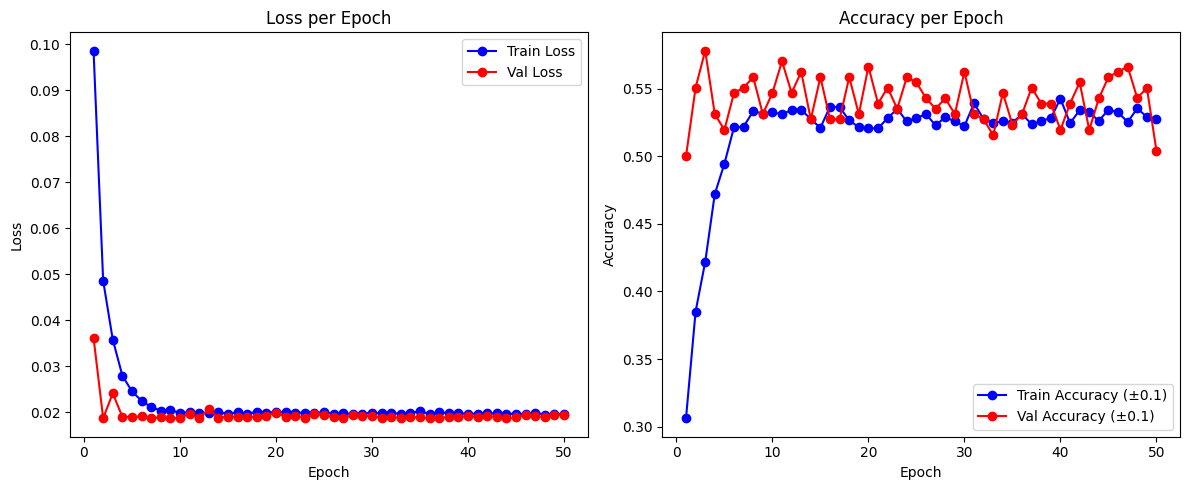

In [ ]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
# audio_model = AudioSentimentModel(input_dim=AUDIO_FEATURE_SIZE, hidden_dim = 256).to(DEVICE)
visual_model = VisualSentimentModel(input_dim=VISUAL_FEATURE_SIZE, hidden_dim = 256).to(DEVICE)
text_model = TextSentimentModel(input_dim=TEXT_EMBEDDING_DIM, hidden_dim = 256).to(DEVICE)

In [ ]:
class TransformerAudioEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, num_heads=4, dropout_rate=0.3):
        super(TransformerAudioEncoder, self).__init__()
        self.input_projection = nn.Linear(input_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dim_feedforward=hidden_dim * 4,
            dropout=dropout_rate, activation="relu", batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_projection = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def get_encoded_features(self, x):
        x = self.input_projection(x)

        if len(x.shape) == 2:
            x = x.unsqueeze(1)

        x = self.transformer_encoder(x)

        encoded = x[:, 0, :]
        return encoded

    def forward(self, x):
        encoded = self.get_encoded_features(x)
        sentiment = self.output_projection(encoded)
        return encoded, sentiment

In [ ]:
class TransformerVisualEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, num_heads=4, dropout_rate=0.3):
        super(TransformerVisualEncoder, self).__init__()
        self.input_projection = nn.Linear(input_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dim_feedforward=hidden_dim * 4,
            dropout=dropout_rate, activation="relu", batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_projection = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def get_encoded_features(self, x):
        x = self.input_projection(x)
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        x = self.transformer_encoder(x)
        encoded = x[:, 0, :]
        return encoded

    def forward(self, x):
        encoded = self.get_encoded_features(x)
        sentiment = self.output_projection(encoded)
        return encoded, sentiment


In [ ]:
class TransformerTextEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_layers=4, num_heads=8, dropout_rate=0.3):
        super(TransformerTextEncoder, self).__init__()
        self.input_projection = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dim_feedforward=hidden_dim * 4,
            dropout=dropout_rate, activation="relu", batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_projection = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def get_encoded_features(self, x):
        # print(f"TransformerTextEncoder input shape: {x.shape}")
        x = self.input_projection(x)
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        # print(f"TransformerTextEncoder after projection: {x.shape}")
        x = self.transformer_encoder(x)
        encoded = x[:, 0, :]
        # print(f"TransformerTextEncoder output shape: {encoded.shape}")
        return encoded

    def forward(self, x):
        encoded = self.get_encoded_features(x)
        sentiment = self.output_projection(encoded)
        return encoded, sentiment

In [ ]:
class EarlyFusionModel(nn.Module):
    def __init__(self, text_dim,  visual_dim, hidden_dim=256, dropout_rate=0.3):
        super(EarlyFusionModel, self).__init__()
        total_dim = text_dim + visual_dim

        self.fusion_layers = nn.Sequential(
            nn.Linear(total_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, text_features,  visual_features):
        concat_features = torch.cat([text_features,  visual_features], dim=1)
        sentiment = self.fusion_layers(concat_features)
        return sentiment


In [ ]:
class LateFusionModel(nn.Module):
    def __init__(self,text_model,  visual_model, fusion_weights=None):
        super(LateFusionModel, self).__init__()
        self.text_model = text_model
        # self.audio_model = audio_model
        self.visual_model = visual_model

        # for model in [self.text_model, self.audio_model, self.visual_model]:
        #     for param in model.parameters():
        #         param.requires_grad = False

        if fusion_weights is None:
            self.fusion_weights = nn.Parameter(torch.ones(2) / 2)
        else:
            self.fusion_weights = torch.tensor(fusion_weights)

    def forward(self, features):
        text_features = features["language"]
        # audio_features = features["acoustic"]
        visual_features = features["visual"]

        # audio_pred = self.audio_model(audio_features)
        visual_pred = self.visual_model(visual_features)
        text_pred = self.text_model(text_features)

        weights = F.softmax(self.fusion_weights, dim=0)

        combined_pred = weights[0] * text_pred +  weights[1] * visual_pred
        return combined_pred

In [ ]:
class TransformerFusionModel(nn.Module):
    def __init__(self, text_dim,  visual_dim, hidden_dim=256, num_heads=8, num_layers=4, dropout_rate=0.3):
        super(TransformerFusionModel, self).__init__()

        self.text_encoder = TransformerTextEncoder(
            text_dim, hidden_dim, num_layers, num_heads, dropout_rate
        )

        # self.audio_encoder = TransformerAudioEncoder(
        #     audio_dim, hidden_dim // 2, num_layers // 2, num_heads // 2, dropout_rate
        # )

        self.visual_encoder = TransformerVisualEncoder(
            visual_dim, hidden_dim // 2, num_layers // 2, num_heads // 2, dropout_rate
        )

        # Multimodal cross-attention fusion
        self.fusion_module = MultimodalCrossAttention(
            hidden_dim, hidden_dim // 2, hidden_dim // 2, hidden_dim, num_heads, dropout_rate
        )

        self.output_proj = nn.Linear(hidden_dim + hidden_dim //2, 1)

    def forward(self, features):
        text_features = features["language"]
        # audio_features = features["acoustic"]
        visual_features = features["visual"]

        print(f"text_features shape: {text_features.shape}")
        # print(f"audio_features shape: {audio_features.shape}")
        print(f"visual_features shape: {visual_features.shape}")

        # Encode each modality using respective transformer encoders
        text_encoded = self.text_encoder.get_encoded_features(text_features)
        # audio_encoded = self.audio_encoder.get_encoded_features(audio_features)
        visual_encoded = self.visual_encoder.get_encoded_features(visual_features)

        fused_features, sentiment = self.fusion_module(
            text_encoded, visual_encoded
        )

        print("Fused shape:", fused_features.shape)
        return sentiment

In [ ]:
input_dims = {
    "language": TEXT_EMBEDDING_DIM,
    # "acoustic": AUDIO_FEATURE_SIZE,
    "visual": VISUAL_FEATURE_SIZE
}
models = {
    "LateFusion": LateFusionModel(text_model,  visual_model),
    "TransformerFusion": TransformerFusionModel(
        text_dim=input_dims["language"],
        # audio_dim=input_dims["acoustic"],
        visual_dim=input_dims["visual"],
        hidden_dim=256,
        num_layers= 4,
        num_heads= 8,
        dropout_rate=0.3
    )
}

In [ ]:
logger = logging.getLogger(__name__)

def calc_mae(preds, labels):
    return mean_absolute_error(labels, preds)

def calc_correlation(preds, labels):
    if np.std(preds) == 0 or np.std(labels) == 0:
        return 0.0

    return np.corrcoef(preds, labels)[0, 1]

def calc_binary_accuracy(preds, labels, threshold=0):
    binary_preds = (preds > threshold).astype(int)
    binary_labels = (labels > threshold).astype(int)

    return accuracy_score(binary_labels, binary_preds)

def calc_f1(preds, labels, threshold=0):
    binary_preds = (preds > threshold).astype(int)
    binary_labels = (labels > threshold).astype(int)

    return f1_score(binary_labels, binary_preds, zero_division=0)

def calc_accuracy(y_true, y_pred):
    print(f"accuracy", accuracy_score(y_true, y_pred))
    return accuracy_score(y_true, y_pred)

def calc_multiclass_metrics(preds, labels):
    # Round to nearest integer and clip to [-3, 3] range
    rounded_preds = np.round(preds).clip(-3, 3)
    rounded_labels = np.round(labels).clip(-3, 3)

    # Convert to 7 classes (0-6 for -3 to +3)
    preds_classes = (rounded_preds + 3).astype(int)
    labels_classes = (rounded_labels + 3).astype(int)

    # Calculate metrics
    acc = accuracy_score(labels_classes, preds_classes)
    f1 = f1_score(labels_classes, preds_classes, average="weighted", zero_division=0)

    return {
        "multiclass_acc": acc,
        "multiclass_f1": f1
    }

def get_predictions(model, dataloader, device):

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            # Get batch data
            if isinstance(batch, dict):
                # Multimodal data
                inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
                labels = batch["label"].to(device)
            else:
                # Unimodal data
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            outputs = torch.nan_to_num(outputs, nan=0.0)

            # Collect predictions and labels
            preds = outputs.squeeze().cpu().numpy()
            labels = labels.cpu().numpy()

            all_preds.append(preds)
            all_labels.append(labels)

    # Concatenate batch results
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    return all_preds, all_labels

def evaluate_mosei(model, dataloader, device):
    all_preds, all_labels = get_predictions(model, dataloader, device)

    # Calculate metrics
    mae = calc_mae(all_preds, all_labels)
    corr = calc_correlation(all_preds, all_labels)
    # acc1 = calc_accuracy(all_labels, all_preds)
    acc = calc_binary_accuracy(all_preds, all_labels)
    f1 = calc_f1(all_preds, all_labels)

    # Multi-class metrics
    multiclass_metrics = calc_multiclass_metrics(all_preds, all_labels)

    # Combine all metrics
    metrics = {
        "mae": mae,
        "corr": corr,
        "binary_acc": acc,
        # "accuracy": acc1,
        "binary_f1": f1,
        **multiclass_metrics
    }

    return metrics

def log_metrics(metrics, split, epoch=None):
    epoch_str = f"Epoch {epoch} - " if epoch is not None else ""
    logger.info(f"{epoch_str}{split.capitalize()} metrics:")
    logger.info(f"  MAE: {metrics['mae']:.4f}")
    logger.info(f"  Correlation: {metrics['corr']:.4f}")
    logger.info(f"  Binary Accuracy: {metrics['binary_acc']:.4f}")
    logger.info(f"  Binary F1: {metrics['binary_f1']:.4f}")
    logger.info(f"  7-class Accuracy: {metrics['multiclass_acc']:.4f}")
    logger.info(f"  7-class F1: {metrics['multiclass_f1']:.4f}")


In [ ]:
class Trainer:
    def __init__(
        self,model,train_loader, val_loader, test_loader=None,lr=1e-4, weight_decay=1e-5,device=None, model_dir=None,log_dir=None, experiment_name=None):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

        # Set device
        self.device = device if device is not None else DEVICE
        self.model = self.model.to(self.device)

        # Setup optimizer and loss function
        self.optimizer = optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )
        self.criterion = nn.MSELoss()

        # Setup paths for saving models and logs
        self.model_dir = Path(model_dir) if model_dir is not None else Path("/content/models")
        self.model_dir.mkdir(exist_ok=True, parents=True)

        # self.log_dir = Path(log_dir) if log_dir is not None else Path(LOGS_DIR)
        # self.log_dir.mkdir(exist_ok=True, parents=True)

        # Set experiment name
        if experiment_name is None:
            self.experiment_name = f"{model.__class__.__name__}_{time.strftime('%Y%m%d_%H%M%S')}"
        else:
            self.experiment_name = experiment_name

        # Setup logging
        # self.log_file = self.log_dir / f"{self.experiment_name}.log"
        # setup_logging(self.log_file)

        # Track best validation performance
        self.best_val_loss = float("inf")
        self.best_epoch = 0
        self.patience_counter = 0

    def train_epoch(self, epoch):
        """
        Train the model for a single epoch.
        """
        self.model.train()
        epoch_loss = 0.0

        # Use tqdm for progress bar
        pbar = tqdm(total=len(self.train_loader), desc=f"Epoch {epoch}")

        for batch_idx, batch in enumerate(self.train_loader):
            # Get batch data
            if isinstance(batch, dict):
                # Multimodal data
                inputs = {k: v.to(self.device) for k, v in batch.items() if k != "label"}
                labels = batch["label"].to(self.device)
            else:
                # Unimodal data
                inputs, labels = batch
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

            # Reset gradients
            self.optimizer.zero_grad()

            # Forward pass
            outputs = self.model(inputs)
            outputs = torch.nan_to_num(outputs, nan=0.0)  # Xử lý NaN trong outputs

            # Calculate loss
            loss = self.criterion(outputs.squeeze(), labels)
            if torch.isnan(loss):
                logger.warning(f"NaN loss detected in epoch {epoch}, batch {batch_idx}")
                continue

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)  # Gradient clipping
            self.optimizer.step()

            # Update statistics
            epoch_loss += loss.item()

            # Update progress bar
            pbar.update(1)
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        pbar.close()

        # Calculate average loss
        avg_loss = epoch_loss / len(self.train_loader)

        return avg_loss

    def validate(self, epoch):

        self.model.eval()
        val_loss = 0.0

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in self.val_loader:
                # Get batch data
                if isinstance(batch, dict):
                    # Multimodal data
                    inputs = {k: v.to(self.device) for k, v in batch.items() if k != "label"}
                    labels = batch["label"].to(self.device)
                else:
                    # Unimodal data
                    inputs, labels = batch
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)

                # Forward pass
                outputs = self.model(inputs)
                outputs = torch.nan_to_num(outputs, nan=0.0)  # Xử lý NaN trong outputs

                # Calculate loss
                loss = self.criterion(outputs.squeeze(), labels)
                if torch.isnan(loss):
                    logger.warning(f"NaN loss detected in validation, epoch {epoch}")
                    continue

                # Update statistics
                val_loss += loss.item()

                # Collect predictions and labels
                preds = outputs.squeeze().cpu().numpy()
                labels = labels.cpu().numpy()

                all_preds.append(preds)
                all_labels.append(labels)

        # print("Sample predictions:", all_preds[:10])
        # print("Sample labels     :", all_labels[:10])

        # Calculate average loss
        avg_loss = val_loss / len(self.val_loader)

        # Concatenate batch results
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        # Xử lý NaN trước khi tính metrics
        if np.any(np.isnan(all_preds)) or np.any(np.isnan(all_labels)):
            logger.warning("NaN detected in predictions or labels, applying nan_to_num")
            all_preds = np.nan_to_num(all_preds, nan=0.0)
            all_labels = np.nan_to_num(all_labels, nan=0.0)

        # Evaluate using metrics
        metrics = evaluate_mosei(self.model, self.val_loader, self.device)

        return avg_loss, metrics

    def test(self):
        """
        Evaluate the best model on the test set.
        """
        if self.test_loader is None:
            logger.warning("Test loader not provided. Skipping test evaluation.")
            return None

        logger.info("Evaluating model on test set...")
        metrics = evaluate_mosei(self.model, self.test_loader, self.device)
        log_metrics(metrics, "test")

        return metrics

    def save_checkpoint(self, epoch, val_loss, is_best=False):
        checkpoint = {
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "val_loss": val_loss,
        }

        # Save regular checkpoint
        checkpoint_path = self.model_dir / f"{self.experiment_name}_epoch_{epoch}.pt"
        torch.save(checkpoint, checkpoint_path)
        logger.info(f"Saved checkpoint to {checkpoint_path}")

        # Save best model
        if is_best:
            best_path = self.model_dir / f"{self.experiment_name}_best.pt"
            torch.save(checkpoint, best_path)
            logger.info(f"Saved best model to {best_path}")

    def load_checkpoint(self, checkpoint_path=None):
        if checkpoint_path is None:
            checkpoint_path = self.model_dir / f"{self.experiment_name}_best.pt"

        if not Path(checkpoint_path).exists():
            logger.warning(f"Checkpoint {checkpoint_path} not found. Skipping.")
            return

        logger.info(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=self.device)

        # Load model and optimizer states
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

        # Set best validation loss
        if "val_loss" in checkpoint:
            self.best_val_loss = checkpoint["val_loss"]
            logger.info(f"Best validation loss: {self.best_val_loss:.4f}")
    #epoch 50
    def train(self, start_epoch=1, num_epochs=5, patience=20, eval_every=1):
        logger.info(f"Starting training for {num_epochs} epochs")
        logger.info(f"Model: {self.model.__class__.__name__}")
        logger.info(f"Device: {self.device}")
        logger.info(f"Train samples: {len(self.train_loader.dataset)}")
        logger.info(f"Validation samples: {len(self.val_loader.dataset)}")
        if self.test_loader is not None:
            logger.info(f"Test samples: {len(self.test_loader.dataset)}")

        best_val_metrics = None
        best_model = None
        self.best_val_loss = float('inf')
        self.best_epoch = 0
        self.patience_counter = 0

        train_losses = []
        val_losses = []
        train_metrics_list = []
        val_metrics_list = []

        for epoch in range(start_epoch, num_epochs + 1):
            # Train for one epoch
            train_loss = self.train_epoch(epoch)
            train_losses.append(train_loss)
            logger.info(f"Epoch {epoch} - Train loss: {train_loss:.4f}")

            if epoch % eval_every == 0:
                val_loss, val_metrics = self.validate(epoch)
                val_losses.append(val_loss)
                val_metrics_list.append(val_metrics)
                logger.info(f"Epoch {epoch} - Validation loss: {val_loss:.4f}")
                log_metrics(val_metrics, "val", epoch)

                train_metrics = evaluate_mosei(self.model, self.train_loader, self.device)
                train_metrics_list.append(train_metrics)
                log_metrics(train_metrics, "train", epoch)

                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    self.best_epoch = epoch
                    best_model = self.model
                    best_val_metrics = val_metrics
                    self.patience_counter = 0

                    self.save_checkpoint(epoch, val_loss, is_best=True)
                    logger.info(f"New best model at epoch {epoch}")
                else:
                    self.patience_counter += 1
                    logger.info(f"No improvement for {self.patience_counter} epochs")

                    if self.patience_counter >= patience:
                        logger.info(f"Early stopping at epoch {epoch}")
                        break

            if epoch % 5 == 0 or epoch == num_epochs:
                self.save_checkpoint(epoch, val_loss if epoch % eval_every == 0 else float("inf"))

        logger.info(f"Training completed. Best model at epoch {self.best_epoch}")

        return best_model, train_losses, val_losses, train_metrics_list, val_metrics_list

In [ ]:
def plot_training_curves(train_losses, val_losses, metrics, save_path, model_name):
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label="Training Loss", color="blue")
    plt.plot(val_losses, label="Validate Loss", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training loss and validate loss - {model_name}")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    for metric_name in ["mae", "corr", "binary_acc", "binary_f1"]:
        plt.plot([m[metric_name] for m in metrics], label=metric_name.capitalize())
    plt.xlabel("Epoch")
    plt.ylabel("Index value")
    plt.title(f"Index validation - {model_name}")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"Saved training curve graph for {model_name} in {save_path}")
    plt.show()
    plt.close()

# Hàm trực quan hóa so sánh mô hình
def plot_results_summary(results, save_path):
    metrics = ["mae", "corr", "binary_acc",  "binary_f1"]
    model_names = list(results.keys())
    metric_values = {metric: [results[model][metric] for model in model_names] for metric in metrics}

    plt.figure(figsize=(12, 6))
    x = np.arange(len(model_names))
    width = 0.2

    for i, metric in enumerate(metrics):
        plt.bar(x + i * width, metric_values[metric], width, label=metric.capitalize())

    plt.xlabel("Model")
    plt.ylabel("Index value")
    plt.title("Compare model")
    plt.xticks(x + width * 1.5, model_names)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"Model comparison chart saved to {save_path}")
    plt.show()
    plt.close()


In [ ]:
results = {}
plot_dir = Path("content/plots")
plot_dir.mkdir(exist_ok=True, parents=True)

for model_name, model in models.items():
    print(f"Training model {model_name}...")
    trainer = Trainer(model, train_loader, val_loader, test_loader)
    best_model, train_losses, val_losses, train_metrics_list, val_metrics_list = trainer.train(num_epochs=5, patience=20)
    print(NUM_EPOCHS)
    # Lưu kết quả
    best_metrics = val_metrics_list[-1]
    results[model_name] = best_metrics

Training model LateFusion...





Epoch 1:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 1:   1%|▏         | 1/74 [00:00<00:00, 87.86it/s, loss=0.1247]


Epoch 1:   3%|▎         | 2/74 [00:00<00:00, 101.10it/s, loss=0.1180]


Epoch 1:   4%|▍         | 3/74 [00:00<00:00, 107.97it/s, loss=0.1388]


Epoch 1:   5%|▌         | 4/74 [00:00<00:00, 111.12it/s, loss=0.0934]


Epoch 1:   7%|▋         | 5/74 [00:00<00:00, 105.03it/s, loss=0.1139]


Epoch 1:   8%|▊         | 6/74 [00:00<00:00, 105.72it/s, loss=0.0842]


Epoch 1:   9%|▉         | 7/74 [00:00<00:00, 105.78it/s, loss=0.0719]


Epoch 1:  11%|█         | 8/74 [00:00<00:00, 106.99it/s, loss=0.1250]


Epoch 1:  12%|█▏        | 9/74 [00:00<00:00, 107.38it/s, loss=0.0598]


Epoch 1:  14%|█▎        | 10/74 [00:00<00:00, 105.62it/s, loss=0.1017]


Epoch 1:  15%|█▍        | 11/74 [00:00<00:00, 106.95it/s, loss=0.1017]


Epoch 1:  15%|█▍        | 11/74 [00:00<00:00, 106.95it/s, loss=0.0880]


Epoch 1:  16%|█▌        | 12/74 [00:00<00:00, 106.95it/s, loss=0.1122]


Epoch 1:

5
Training model TransformerFusion...





Epoch 1:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 1:   1%|▏         | 1/74 [00:00<00:09,  7.85it/s]


Epoch 1:   1%|▏         | 1/74 [00:00<00:09,  7.85it/s, loss=0.2649]


Epoch 1:   3%|▎         | 2/74 [00:00<00:09,  7.85it/s, loss=0.3133]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 1:   4%|▍         | 3/74 [00:00<00:09,  7.85it/s, loss=0.3024]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])





Epoch 1:   5%|▌         | 4/74 [00:00<00:08,  7.85it/s, loss=0.1122]


Epoch 1:   7%|▋         | 5/74 [00:00<00:03, 22.47it/s, loss=0.1122]


Epoch 1:   7%|▋         | 5/74 [00:00<00:03, 22.47it/s, loss=0.2580]


Epoch 1:   8%|▊         | 6/74 [00:00<00:03, 22.47it/s, loss=0.1796]


Epoch 1:   9%|▉         | 7/74 [00:00<00:02, 22.47it/s, loss=0.0882]


Epoch 1:  11%|█         | 8/74 [00:00<00:02, 22.47it/s, loss=0.1048]


Epoch 1:  12%|█▏        | 9/74 [00:00<00:02, 29.14it/s, loss=0.1048]


Epoch 1:  12%|█▏        | 9/74 [00:00<00:02, 29.14it/s, loss=0.1292]


Epoch 1:  14%|█▎        | 10/74 [00:00<00:02, 29.14it/s, loss=0.1524]

Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 1:  15%|█▍        | 11/74 [00:00<00:02, 29.14it/s, loss=0.1254]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])





Epoch 1:  16%|█▌        | 12/74 [00:00<00:02, 29.14it/s, loss=0.1362]


Epoch 1:  18%|█▊        | 13/74 [00:00<00:01, 33.07it/s, loss=0.1362]


Epoch 1:  18%|█▊        | 13/74 [00:00<00:01, 33.07it/s, loss=0.1569]


Epoch 1:  19%|█▉        | 14/74 [00:00<00:01, 33.07it/s, loss=0.1289]


Epoch 1:  20%|██        | 15/74 [00:00<00:01, 33.07it/s, loss=0.1477]


Epoch 1:  22%|██▏       | 16/74 [00:00<00:01, 33.07it/s, loss=0.0981]


Epoch 1:  23%|██▎       | 17/74 [00:00<00:01, 33.07it/s, loss=0.0760]


Epoch 1:  24%|██▍       | 18/74 [00:00<00:01, 36.13it/s, loss=0.0760]


Epoch 1:  24%|██▍       | 18/74 [00:00<00:01, 36.13it/s, loss=0.0678]


Epoch 1:  26%|██▌       | 19/74 [00:00<00:01, 36.13it/s, loss=0.0954]

Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size(




Epoch 1:  27%|██▋       | 20/74 [00:00<00:01, 36.13it/s, loss=0.0642]


Epoch 1:  28%|██▊       | 21/74 [00:00<00:01, 36.13it/s, loss=0.0549]


Epoch 1:  30%|██▉       | 22/74 [00:00<00:01, 36.74it/s, loss=0.0549]


Epoch 1:  30%|██▉       | 22/74 [00:00<00:01, 36.74it/s, loss=0.0769]


Epoch 1:  31%|███       | 23/74 [00:00<00:01, 36.74it/s, loss=0.0829]


Epoch 1:  32%|███▏      | 24/74 [00:00<00:01, 36.74it/s, loss=0.0707]


Epoch 1:  34%|███▍      | 25/74 [00:00<00:01, 36.74it/s, loss=0.0999]


Epoch 1:  35%|███▌      | 26/74 [00:00<00:01, 37.01it/s, loss=0.0999]


Epoch 1:  35%|███▌      | 26/74 [00:00<00:01, 37.01it/s, loss=0.0815]


Epoch 1:  36%|███▋      | 27/74 [00:00<00:01, 37.01it/s, loss=0.1003]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 1:  38%|███▊      | 28/74 [00:00<00:01, 37.01it/s, loss=0.0967]


Epoch 1:  39%|███▉      | 29/74 [00:00<00:01, 37.01it/s, loss=0.0789]


Epoch 1:  41%|████      | 30/74 [00:00<00:01, 37.63it/s, loss=0.0789]


Epoch 1:  41%|████      | 30/74 [00:00<00:01, 37.63it/s, loss=0.0933]


Epoch 1:  42%|████▏     | 31/74 [00:00<00:01, 37.63it/s, loss=0.0636]


Epoch 1:  43%|████▎     | 32/74 [00:00<00:01, 37.63it/s, loss=0.0342]


Epoch 1:  45%|████▍     | 33/74 [00:00<00:01, 37.63it/s, loss=0.0611]


Epoch 1:  46%|████▌     | 34/74 [00:00<00:01, 37.63it/s, loss=0.0560]


Epoch 1:  47%|████▋     | 35/74 [00:01<00:01, 38.63it/s, loss=0.0560]


Epoch 1:  47%|████▋     | 35/74 [00:01<00:01, 38.63it/s, loss=0.0732]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])


text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 1:  49%|████▊     | 36/74 [00:01<00:00, 38.63it/s, loss=0.0716]


Epoch 1:  50%|█████     | 37/74 [00:01<00:00, 38.63it/s, loss=0.0798]


Epoch 1:  51%|█████▏    | 38/74 [00:01<00:00, 38.63it/s, loss=0.0460]


Epoch 1:  53%|█████▎    | 39/74 [00:01<00:00, 35.12it/s, loss=0.0460]


Epoch 1:  53%|█████▎    | 39/74 [00:01<00:00, 35.12it/s, loss=0.0412]


Epoch 1:  54%|█████▍    | 40/74 [00:01<00:00, 35.12it/s, loss=0.0614]


Epoch 1:  55%|█████▌    | 41/74 [00:01<00:00, 35.12it/s, loss=0.0493]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])





Epoch 1:  57%|█████▋    | 42/74 [00:01<00:00, 35.12it/s, loss=0.0416]


Epoch 1:  58%|█████▊    | 43/74 [00:01<00:00, 35.29it/s, loss=0.0416]


Epoch 1:  58%|█████▊    | 43/74 [00:01<00:00, 35.29it/s, loss=0.0678]

Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])





Epoch 1:  59%|█████▉    | 44/74 [00:01<00:00, 35.29it/s, loss=0.0567]


Epoch 1:  61%|██████    | 45/74 [00:01<00:00, 35.29it/s, loss=0.0520]


Epoch 1:  62%|██████▏   | 46/74 [00:01<00:00, 35.29it/s, loss=0.0522]


Epoch 1:  64%|██████▎   | 47/74 [00:01<00:00, 36.45it/s, loss=0.0522]


Epoch 1:  64%|██████▎   | 47/74 [00:01<00:00, 36.45it/s, loss=0.0399]


Epoch 1:  65%|██████▍   | 48/74 [00:01<00:00, 36.45it/s, loss=0.0638]


Epoch 1:  66%|██████▌   | 49/74 [00:01<00:00, 36.45it/s, loss=0.0739]

Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])





Epoch 1:  68%|██████▊   | 50/74 [00:01<00:00, 36.45it/s, loss=0.0520]


Epoch 1:  69%|██████▉   | 51/74 [00:01<00:00, 37.01it/s, loss=0.0520]


Epoch 1:  69%|██████▉   | 51/74 [00:01<00:00, 37.01it/s, loss=0.0356]

Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])





Epoch 1:  70%|███████   | 52/74 [00:01<00:00, 37.01it/s, loss=0.0456]


Epoch 1:  72%|███████▏  | 53/74 [00:01<00:00, 37.01it/s, loss=0.0334]


Epoch 1:  73%|███████▎  | 54/74 [00:01<00:00, 37.01it/s, loss=0.0415]


Epoch 1:  74%|███████▍  | 55/74 [00:01<00:00, 37.56it/s, loss=0.0415]


Epoch 1:  74%|███████▍  | 55/74 [00:01<00:00, 37.56it/s, loss=0.0620]


Epoch 1:  76%|███████▌  | 56/74 [00:01<00:00, 37.56it/s, loss=0.0522]


Epoch 1:  77%|███████▋  | 57/74 [00:01<00:00, 37.56it/s, loss=0.0450]

Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])





Epoch 1:  78%|███████▊  | 58/74 [00:01<00:00, 37.56it/s, loss=0.0298]


Epoch 1:  80%|███████▉  | 59/74 [00:01<00:00, 37.37it/s, loss=0.0298]


Epoch 1:  80%|███████▉  | 59/74 [00:01<00:00, 37.37it/s, loss=0.0442]

Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 1:  81%|████████  | 60/74 [00:01<00:00, 37.37it/s, loss=0.0334]


Epoch 1:  82%|████████▏ | 61/74 [00:01<00:00, 37.37it/s, loss=0.0331]


Epoch 1:  84%|████████▍ | 62/74 [00:01<00:00, 37.37it/s, loss=0.0313]


Epoch 1:  85%|████████▌ | 63/74 [00:01<00:00, 37.20it/s, loss=0.0313]


Epoch 1:  85%|████████▌ | 63/74 [00:01<00:00, 37.20it/s, loss=0.0246]


Epoch 1:  86%|████████▋ | 64/74 [00:01<00:00, 37.20it/s, loss=0.0330]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 1:  88%|████████▊ | 65/74 [00:01<00:00, 37.20it/s, loss=0.0234]


Epoch 1:  89%|████████▉ | 66/74 [00:01<00:00, 37.20it/s, loss=0.0472]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 1:  91%|█████████ | 67/74 [00:01<00:00, 37.36it/s, loss=0.0472]


Epoch 1:  91%|█████████ | 67/74 [00:01<00:00, 37.36it/s, loss=0.0295]


Epoch 1:  92%|█████████▏| 68/74 [00:01<00:00, 37.36it/s, loss=0.0278]


Epoch 1:  93%|█████████▎| 69/74 [00:01<00:00, 37.36it/s, loss=0.0271]


Epoch 1:  95%|█████████▍| 70/74 [00:01<00:00, 37.36it/s, loss=0.0318]


Epoch 1:  96%|█████████▌| 71/74 [00:02<00:00, 37.34it/s, loss=0.0318]


Epoch 1:  96%|█████████▌| 71/74 [00:02<00:00, 37.34it/s, loss=0.0316]


Epoch 1:  97%|█████████▋| 72/74 [00:02<00:00, 37.34it/s, loss=0.0451]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 1:  99%|█████████▊| 73/74 [00:02<00:00, 37.34it/s, loss=0.0413]


Epoch 1: 100%|██████████| 74/74 [00:02<00:00, 35.40it/s, loss=0.0372]


text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: tor




Epoch 2:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 2:   1%|▏         | 1/74 [00:00<00:01, 38.01it/s, loss=0.0516]


Epoch 2:   3%|▎         | 2/74 [00:00<00:01, 37.65it/s, loss=0.0246]


Epoch 2:   4%|▍         | 3/74 [00:00<00:01, 38.06it/s, loss=0.0174]


Epoch 2:   5%|▌         | 4/74 [00:00<00:01, 37.93it/s, loss=0.0174]


Epoch 2:   5%|▌         | 4/74 [00:00<00:01, 37.93it/s, loss=0.0364]


Epoch 2:   7%|▋         | 5/74 [00:00<00:01, 37.93it/s, loss=0.0504]


Epoch 2:   8%|▊         | 6/74 [00:00<00:01, 37.93it/s, loss=0.0276]


Epoch 2:   9%|▉         | 7/74 [00:00<00:01, 37.93it/s, loss=0.0489]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 2:  11%|█         | 8/74 [00:00<00:01, 35.81it/s, loss=0.0489]


Epoch 2:  11%|█         | 8/74 [00:00<00:01, 35.81it/s, loss=0.0335]


Epoch 2:  12%|█▏        | 9/74 [00:00<00:01, 35.81it/s, loss=0.0320]


Epoch 2:  14%|█▎        | 10/74 [00:00<00:01, 35.81it/s, loss=0.0270]


Epoch 2:  15%|█▍        | 11/74 [00:00<00:01, 35.81it/s, loss=0.0416]


Epoch 2:  16%|█▌        | 12/74 [00:00<00:01, 32.75it/s, loss=0.0416]


Epoch 2:  16%|█▌        | 12/74 [00:00<00:01, 32.75it/s, loss=0.0312]


Epoch 2:  18%|█▊        | 13/74 [00:00<00:01, 32.75it/s, loss=0.0375]


Epoch 2:  19%|█▉        | 14/74 [00:00<00:01, 32.75it/s, loss=0.0351]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 2:  20%|██        | 15/74 [00:00<00:01, 32.75it/s, loss=0.0332]


Epoch 2:  22%|██▏       | 16/74 [00:00<00:01, 32.88it/s, loss=0.0332]


Epoch 2:  22%|██▏       | 16/74 [00:00<00:01, 32.88it/s, loss=0.0359]


Epoch 2:  23%|██▎       | 17/74 [00:00<00:01, 32.88it/s, loss=0.0269]


Epoch 2:  24%|██▍       | 18/74 [00:00<00:01, 32.88it/s, loss=0.0423]


Epoch 2:  26%|██▌       | 19/74 [00:00<00:01, 32.88it/s, loss=0.0250]


Epoch 2:  27%|██▋       | 20/74 [00:00<00:01, 34.40it/s, loss=0.0250]


Epoch 2:  27%|██▋       | 20/74 [00:00<00:01, 34.40it/s, loss=0.0382]


Epoch 2:  28%|██▊       | 21/74 [00:00<00:01, 34.40it/s, loss=0.0412]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 2:  30%|██▉       | 22/74 [00:00<00:01, 34.40it/s, loss=0.0408]


Epoch 2:  31%|███       | 23/74 [00:00<00:01, 34.40it/s, loss=0.0225]


Epoch 2:  32%|███▏      | 24/74 [00:00<00:01, 35.72it/s, loss=0.0225]


Epoch 2:  32%|███▏      | 24/74 [00:00<00:01, 35.72it/s, loss=0.0337]


Epoch 2:  34%|███▍      | 25/74 [00:00<00:01, 35.72it/s, loss=0.0230]


Epoch 2:  35%|███▌      | 26/74 [00:00<00:01, 35.72it/s, loss=0.0303]


Epoch 2:  36%|███▋      | 27/74 [00:00<00:01, 35.72it/s, loss=0.0137]


Epoch 2:  38%|███▊      | 28/74 [00:00<00:01, 36.46it/s, loss=0.0137]


Epoch 2:  38%|███▊      | 28/74 [00:00<00:01, 36.46it/s, loss=0.0270]


Epoch 2:  39%|███▉      | 29/74 [00:00<00:01, 36.46it/s, loss=0.0312]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 2:  41%|████      | 30/74 [00:00<00:01, 36.46it/s, loss=0.0456]


Epoch 2:  42%|████▏     | 31/74 [00:00<00:01, 36.46it/s, loss=0.0240]


Epoch 2:  43%|████▎     | 32/74 [00:00<00:01, 35.97it/s, loss=0.0240]


Epoch 2:  43%|████▎     | 32/74 [00:00<00:01, 35.97it/s, loss=0.0266]


Epoch 2:  45%|████▍     | 33/74 [00:00<00:01, 35.97it/s, loss=0.0318]


Epoch 2:  46%|████▌     | 34/74 [00:00<00:01, 35.97it/s, loss=0.0333]


Epoch 2:  47%|████▋     | 35/74 [00:00<00:01, 35.97it/s, loss=0.0347]


Epoch 2:  49%|████▊     | 36/74 [00:01<00:01, 36.58it/s, loss=0.0347]


Epoch 2:  49%|████▊     | 36/74 [00:01<00:01, 36.58it/s, loss=0.0181]


Epoch 2:  50%|█████     | 37/74 [00:01<00:01, 36.58it/s, loss=0.0272]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 2:  51%|█████▏    | 38/74 [00:01<00:00, 36.58it/s, loss=0.0176]


Epoch 2:  53%|█████▎    | 39/74 [00:01<00:00, 36.58it/s, loss=0.0236]


Epoch 2:  54%|█████▍    | 40/74 [00:01<00:00, 36.15it/s, loss=0.0236]


Epoch 2:  54%|█████▍    | 40/74 [00:01<00:00, 36.15it/s, loss=0.0280]


Epoch 2:  55%|█████▌    | 41/74 [00:01<00:00, 36.15it/s, loss=0.0418]


Epoch 2:  57%|█████▋    | 42/74 [00:01<00:00, 36.15it/s, loss=0.0207]


Epoch 2:  58%|█████▊    | 43/74 [00:01<00:00, 36.15it/s, loss=0.0472]


Epoch 2:  59%|█████▉    | 44/74 [00:01<00:00, 33.73it/s, loss=0.0472]


Epoch 2:  59%|█████▉    | 44/74 [00:01<00:00, 33.73it/s, loss=0.0245]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 2:  61%|██████    | 45/74 [00:01<00:00, 33.73it/s, loss=0.0357]


Epoch 2:  62%|██████▏   | 46/74 [00:01<00:00, 33.73it/s, loss=0.0315]


Epoch 2:  64%|██████▎   | 47/74 [00:01<00:00, 33.73it/s, loss=0.0225]


Epoch 2:  65%|██████▍   | 48/74 [00:01<00:00, 34.69it/s, loss=0.0225]


Epoch 2:  65%|██████▍   | 48/74 [00:01<00:00, 34.69it/s, loss=0.0259]


Epoch 2:  66%|██████▌   | 49/74 [00:01<00:00, 34.69it/s, loss=0.0334]


Epoch 2:  68%|██████▊   | 50/74 [00:01<00:00, 34.69it/s, loss=0.0411]


Epoch 2:  69%|██████▉   | 51/74 [00:01<00:00, 34.69it/s, loss=0.0227]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])





Epoch 2:  70%|███████   | 52/74 [00:01<00:00, 34.60it/s, loss=0.0227]


Epoch 2:  70%|███████   | 52/74 [00:01<00:00, 34.60it/s, loss=0.0277]


Epoch 2:  72%|███████▏  | 53/74 [00:01<00:00, 34.60it/s, loss=0.0235]


Epoch 2:  73%|███████▎  | 54/74 [00:01<00:00, 34.60it/s, loss=0.0344]


Epoch 2:  74%|███████▍  | 55/74 [00:01<00:00, 34.60it/s, loss=0.0318]


Epoch 2:  76%|███████▌  | 56/74 [00:01<00:00, 35.81it/s, loss=0.0318]


Epoch 2:  76%|███████▌  | 56/74 [00:01<00:00, 35.81it/s, loss=0.0242]


Epoch 2:  77%|███████▋  | 57/74 [00:01<00:00, 35.81it/s, loss=0.0211]


Epoch 2:  78%|███████▊  | 58/74 [00:01<00:00, 35.81it/s, loss=0.0231]


Epoch 2:  80%|███████▉  | 59/74 [00:01<00:00, 35.81it/s, loss=0.0488]

Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])





Epoch 2:  81%|████████  | 60/74 [00:01<00:00, 36.26it/s, loss=0.0488]


Epoch 2:  81%|████████  | 60/74 [00:01<00:00, 36.26it/s, loss=0.0299]


Epoch 2:  82%|████████▏ | 61/74 [00:01<00:00, 36.26it/s, loss=0.0199]


Epoch 2:  84%|████████▍ | 62/74 [00:01<00:00, 36.26it/s, loss=0.0251]


Epoch 2:  85%|████████▌ | 63/74 [00:01<00:00, 36.26it/s, loss=0.0223]


Epoch 2:  86%|████████▋ | 64/74 [00:01<00:00, 36.93it/s, loss=0.0223]


Epoch 2:  86%|████████▋ | 64/74 [00:01<00:00, 36.93it/s, loss=0.0175]


Epoch 2:  88%|████████▊ | 65/74 [00:01<00:00, 36.93it/s, loss=0.0173]


Epoch 2:  89%|████████▉ | 66/74 [00:01<00:00, 36.93it/s, loss=0.0166]


Epoch 2:  91%|█████████ | 67/74 [00:01<00:00, 36.93it/s, loss=0.0321]

Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])





Epoch 2:  92%|█████████▏| 68/74 [00:01<00:00, 37.21it/s, loss=0.0321]


Epoch 2:  92%|█████████▏| 68/74 [00:01<00:00, 37.21it/s, loss=0.0224]


Epoch 2:  93%|█████████▎| 69/74 [00:01<00:00, 37.21it/s, loss=0.0312]


Epoch 2:  95%|█████████▍| 70/74 [00:01<00:00, 37.21it/s, loss=0.0277]


Epoch 2:  96%|█████████▌| 71/74 [00:01<00:00, 37.21it/s, loss=0.0314]


Epoch 2:  97%|█████████▋| 72/74 [00:02<00:00, 37.21it/s, loss=0.0150]


Epoch 2:  99%|█████████▊| 73/74 [00:02<00:00, 38.30it/s, loss=0.0150]


Epoch 2:  99%|█████████▊| 73/74 [00:02<00:00, 38.30it/s, loss=0.0228]


Epoch 2: 100%|██████████| 74/74 [00:02<00:00, 35.91it/s, loss=0.0175]


Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size(




Epoch 3:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 3:   1%|▏         | 1/74 [00:00<00:02, 30.87it/s, loss=0.0302]


Epoch 3:   3%|▎         | 2/74 [00:00<00:02, 34.52it/s, loss=0.0151]


Epoch 3:   4%|▍         | 3/74 [00:00<00:02, 35.14it/s, loss=0.0297]


Epoch 3:   5%|▌         | 4/74 [00:00<00:01, 36.07it/s, loss=0.0297]


Epoch 3:   5%|▌         | 4/74 [00:00<00:01, 36.07it/s, loss=0.0266]


Epoch 3:   7%|▋         | 5/74 [00:00<00:01, 36.07it/s, loss=0.0234]


Epoch 3:   8%|▊         | 6/74 [00:00<00:01, 36.07it/s, loss=0.0108]


Epoch 3:   9%|▉         | 7/74 [00:00<00:01, 36.07it/s, loss=0.0184]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])





Epoch 3:  11%|█         | 8/74 [00:00<00:01, 34.84it/s, loss=0.0184]


Epoch 3:  11%|█         | 8/74 [00:00<00:01, 34.84it/s, loss=0.0268]


Epoch 3:  12%|█▏        | 9/74 [00:00<00:01, 34.84it/s, loss=0.0256]


Epoch 3:  14%|█▎        | 10/74 [00:00<00:01, 34.84it/s, loss=0.0247]


Epoch 3:  15%|█▍        | 11/74 [00:00<00:01, 34.84it/s, loss=0.0142]


Epoch 3:  16%|█▌        | 12/74 [00:00<00:01, 31.65it/s, loss=0.0142]


Epoch 3:  16%|█▌        | 12/74 [00:00<00:01, 31.65it/s, loss=0.0186]


Epoch 3:  18%|█▊        | 13/74 [00:00<00:01, 31.65it/s, loss=0.0254]

Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 3:  19%|█▉        | 14/74 [00:00<00:01, 31.65it/s, loss=0.0165]


Epoch 3:  20%|██        | 15/74 [00:00<00:01, 31.65it/s, loss=0.0173]


Epoch 3:  22%|██▏       | 16/74 [00:00<00:01, 33.87it/s, loss=0.0173]


Epoch 3:  22%|██▏       | 16/74 [00:00<00:01, 33.87it/s, loss=0.0142]


Epoch 3:  23%|██▎       | 17/74 [00:00<00:01, 33.87it/s, loss=0.0507]


Epoch 3:  24%|██▍       | 18/74 [00:00<00:01, 33.87it/s, loss=0.0265]


Epoch 3:  26%|██▌       | 19/74 [00:00<00:01, 33.87it/s, loss=0.0280]


Epoch 3:  27%|██▋       | 20/74 [00:00<00:01, 34.74it/s, loss=0.0280]


Epoch 3:  27%|██▋       | 20/74 [00:00<00:01, 34.74it/s, loss=0.0240]


Epoch 3:  28%|██▊       | 21/74 [00:00<00:01, 34.74it/s, loss=0.0406]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])





Epoch 3:  30%|██▉       | 22/74 [00:00<00:01, 34.74it/s, loss=0.0195]


Epoch 3:  31%|███       | 23/74 [00:00<00:01, 34.74it/s, loss=0.0179]


Epoch 3:  32%|███▏      | 24/74 [00:00<00:01, 32.63it/s, loss=0.0179]


Epoch 3:  32%|███▏      | 24/74 [00:00<00:01, 32.63it/s, loss=0.0209]


Epoch 3:  34%|███▍      | 25/74 [00:00<00:01, 32.63it/s, loss=0.0249]


Epoch 3:  35%|███▌      | 26/74 [00:00<00:01, 32.63it/s, loss=0.0310]


Epoch 3:  36%|███▋      | 27/74 [00:00<00:01, 32.63it/s, loss=0.0276]


Epoch 3:  38%|███▊      | 28/74 [00:00<00:01, 33.26it/s, loss=0.0276]




Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])


Epoch 3:  38%|███▊      | 28/74 [00:00<00:01, 33.26it/s, loss=0.0120]


Epoch 3:  39%|███▉      | 29/74 [00:00<00:01, 33.26it/s, loss=0.0287]


Epoch 3:  41%|████      | 30/74 [00:00<00:01, 33.26it/s, loss=0.0150]


Epoch 3:  42%|████▏     | 31/74 [00:00<00:01, 33.26it/s, loss=0.0284]


Epoch 3:  43%|████▎     | 32/74 [00:00<00:01, 31.84it/s, loss=0.0284]


Epoch 3:  43%|████▎     | 32/74 [00:00<00:01, 31.84it/s, loss=0.0266]


Epoch 3:  45%|████▍     | 33/74 [00:01<00:01, 31.84it/s, loss=0.0183]


Epoch 3:  46%|████▌     | 34/74 [00:01<00:01, 31.84it/s, loss=0.0147]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])





Epoch 3:  47%|████▋     | 35/74 [00:01<00:01, 31.84it/s, loss=0.0284]


Epoch 3:  49%|████▊     | 36/74 [00:01<00:01, 32.48it/s, loss=0.0284]


Epoch 3:  49%|████▊     | 36/74 [00:01<00:01, 32.48it/s, loss=0.0121]


Epoch 3:  50%|█████     | 37/74 [00:01<00:01, 32.48it/s, loss=0.0270]


Epoch 3:  51%|█████▏    | 38/74 [00:01<00:01, 32.48it/s, loss=0.0286]


Epoch 3:  53%|█████▎    | 39/74 [00:01<00:01, 32.48it/s, loss=0.0314]


Epoch 3:  54%|█████▍    | 40/74 [00:01<00:01, 32.40it/s, loss=0.0314]


Epoch 3:  54%|█████▍    | 40/74 [00:01<00:01, 32.40it/s, loss=0.0122]


Epoch 3:  55%|█████▌    | 41/74 [00:01<00:01, 32.40it/s, loss=0.0187]

Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 3:  57%|█████▋    | 42/74 [00:01<00:00, 32.40it/s, loss=0.0258]


Epoch 3:  58%|█████▊    | 43/74 [00:01<00:00, 32.40it/s, loss=0.0183]


Epoch 3:  59%|█████▉    | 44/74 [00:01<00:00, 31.25it/s, loss=0.0183]


Epoch 3:  59%|█████▉    | 44/74 [00:01<00:00, 31.25it/s, loss=0.0127]


Epoch 3:  61%|██████    | 45/74 [00:01<00:00, 31.25it/s, loss=0.0287]


Epoch 3:  62%|██████▏   | 46/74 [00:01<00:00, 31.25it/s, loss=0.0140]


Epoch 3:  64%|██████▎   | 47/74 [00:01<00:00, 31.25it/s, loss=0.0296]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 3:  65%|██████▍   | 48/74 [00:01<00:00, 32.30it/s, loss=0.0296]


Epoch 3:  65%|██████▍   | 48/74 [00:01<00:00, 32.30it/s, loss=0.0345]


Epoch 3:  66%|██████▌   | 49/74 [00:01<00:00, 32.30it/s, loss=0.0169]


Epoch 3:  68%|██████▊   | 50/74 [00:01<00:00, 32.30it/s, loss=0.0141]


Epoch 3:  69%|██████▉   | 51/74 [00:01<00:00, 32.30it/s, loss=0.0209]


Epoch 3:  70%|███████   | 52/74 [00:01<00:00, 33.90it/s, loss=0.0209]


Epoch 3:  70%|███████   | 52/74 [00:01<00:00, 33.90it/s, loss=0.0169]


Epoch 3:  72%|███████▏  | 53/74 [00:01<00:00, 33.90it/s, loss=0.0211]


Epoch 3:  73%|███████▎  | 54/74 [00:01<00:00, 33.90it/s, loss=0.0225]


Epoch 3:  74%|███████▍  | 55/74 [00:01<00:00, 33.90it/s, loss=0.0321]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 3:  76%|███████▌  | 56/74 [00:01<00:00, 33.70it/s, loss=0.0321]


Epoch 3:  76%|███████▌  | 56/74 [00:01<00:00, 33.70it/s, loss=0.0189]


Epoch 3:  77%|███████▋  | 57/74 [00:01<00:00, 33.70it/s, loss=0.0178]


Epoch 3:  78%|███████▊  | 58/74 [00:01<00:00, 33.70it/s, loss=0.0204]


Epoch 3:  80%|███████▉  | 59/74 [00:01<00:00, 33.70it/s, loss=0.0265]


Epoch 3:  81%|████████  | 60/74 [00:01<00:00, 34.44it/s, loss=0.0265]


Epoch 3:  81%|████████  | 60/74 [00:01<00:00, 34.44it/s, loss=0.0205]


Epoch 3:  82%|████████▏ | 61/74 [00:01<00:00, 34.44it/s, loss=0.0148]


Epoch 3:  84%|████████▍ | 62/74 [00:01<00:00, 34.44it/s, loss=0.0200]


Epoch 3:  85%|████████▌ | 63/74 [00:01<00:00, 34.44it/s, loss=0.0171]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 3:  86%|████████▋ | 64/74 [00:01<00:00, 35.36it/s, loss=0.0171]


Epoch 3:  86%|████████▋ | 64/74 [00:01<00:00, 35.36it/s, loss=0.0261]


Epoch 3:  88%|████████▊ | 65/74 [00:01<00:00, 35.36it/s, loss=0.0282]


Epoch 3:  89%|████████▉ | 66/74 [00:01<00:00, 35.36it/s, loss=0.0176]


Epoch 3:  91%|█████████ | 67/74 [00:01<00:00, 35.36it/s, loss=0.0182]


Epoch 3:  92%|█████████▏| 68/74 [00:02<00:00, 35.67it/s, loss=0.0182]


Epoch 3:  92%|█████████▏| 68/74 [00:02<00:00, 35.67it/s, loss=0.0170]


Epoch 3:  93%|█████████▎| 69/74 [00:02<00:00, 35.67it/s, loss=0.0157]


Epoch 3:  95%|█████████▍| 70/74 [00:02<00:00, 35.67it/s, loss=0.0173]


Epoch 3:  96%|█████████▌| 71/74 [00:02<00:00, 35.67it/s, loss=0.0141]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 3:  97%|█████████▋| 72/74 [00:02<00:00, 36.22it/s, loss=0.0141]


Epoch 3:  97%|█████████▋| 72/74 [00:02<00:00, 36.22it/s, loss=0.0147]


Epoch 3:  99%|█████████▊| 73/74 [00:02<00:00, 36.22it/s, loss=0.0154]


Epoch 3: 100%|██████████| 74/74 [00:02<00:00, 33.79it/s, loss=0.0256]


text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: tor




Epoch 4:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 4:   1%|▏         | 1/74 [00:00<00:02, 31.36it/s, loss=0.0122]


Epoch 4:   3%|▎         | 2/74 [00:00<00:02, 34.78it/s, loss=0.0254]


Epoch 4:   4%|▍         | 3/74 [00:00<00:01, 36.02it/s, loss=0.0146]


Epoch 4:   5%|▌         | 4/74 [00:00<00:01, 36.35it/s, loss=0.0146]


Epoch 4:   5%|▌         | 4/74 [00:00<00:01, 36.35it/s, loss=0.0122]


Epoch 4:   7%|▋         | 5/74 [00:00<00:01, 36.35it/s, loss=0.0128]


Epoch 4:   8%|▊         | 6/74 [00:00<00:01, 36.35it/s, loss=0.0158]


Epoch 4:   9%|▉         | 7/74 [00:00<00:01, 36.35it/s, loss=0.0225]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 4:  11%|█         | 8/74 [00:00<00:01, 34.05it/s, loss=0.0225]


Epoch 4:  11%|█         | 8/74 [00:00<00:01, 34.05it/s, loss=0.0281]


Epoch 4:  12%|█▏        | 9/74 [00:00<00:01, 34.05it/s, loss=0.0217]


Epoch 4:  14%|█▎        | 10/74 [00:00<00:01, 34.05it/s, loss=0.0251]


Epoch 4:  15%|█▍        | 11/74 [00:00<00:01, 34.05it/s, loss=0.0264]


Epoch 4:  16%|█▌        | 12/74 [00:00<00:01, 34.25it/s, loss=0.0264]


Epoch 4:  16%|█▌        | 12/74 [00:00<00:01, 34.25it/s, loss=0.0142]


Epoch 4:  18%|█▊        | 13/74 [00:00<00:01, 34.25it/s, loss=0.0190]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])





Epoch 4:  19%|█▉        | 14/74 [00:00<00:01, 34.25it/s, loss=0.0202]


Epoch 4:  20%|██        | 15/74 [00:00<00:01, 34.25it/s, loss=0.0071]


Epoch 4:  22%|██▏       | 16/74 [00:00<00:01, 29.40it/s, loss=0.0071]


Epoch 4:  22%|██▏       | 16/74 [00:00<00:01, 29.40it/s, loss=0.0168]


Epoch 4:  23%|██▎       | 17/74 [00:00<00:01, 29.40it/s, loss=0.0192]

Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 4:  24%|██▍       | 18/74 [00:00<00:01, 29.40it/s, loss=0.0177]


Epoch 4:  26%|██▌       | 19/74 [00:00<00:01, 29.40it/s, loss=0.0241]


Epoch 4:  27%|██▋       | 20/74 [00:00<00:02, 24.84it/s, loss=0.0241]


Epoch 4:  27%|██▋       | 20/74 [00:00<00:02, 24.84it/s, loss=0.0208]


Epoch 4:  28%|██▊       | 21/74 [00:00<00:02, 24.84it/s, loss=0.0144]


Epoch 4:  30%|██▉       | 22/74 [00:00<00:02, 24.84it/s, loss=0.0136]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 4:  31%|███       | 23/74 [00:00<00:02, 24.62it/s, loss=0.0136]


Epoch 4:  31%|███       | 23/74 [00:00<00:02, 24.62it/s, loss=0.0138]


Epoch 4:  32%|███▏      | 24/74 [00:00<00:02, 24.62it/s, loss=0.0195]


Epoch 4:  34%|███▍      | 25/74 [00:00<00:01, 24.62it/s, loss=0.0209]


Epoch 4:  35%|███▌      | 26/74 [00:00<00:01, 25.28it/s, loss=0.0209]


Epoch 4:  35%|███▌      | 26/74 [00:00<00:01, 25.28it/s, loss=0.0242]


Epoch 4:  36%|███▋      | 27/74 [00:01<00:01, 25.28it/s, loss=0.0224]


Epoch 4:  38%|███▊      | 28/74 [00:01<00:01, 25.28it/s, loss=0.0241]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])





Epoch 4:  39%|███▉      | 29/74 [00:01<00:01, 25.37it/s, loss=0.0241]


Epoch 4:  39%|███▉      | 29/74 [00:01<00:01, 25.37it/s, loss=0.0140]


Epoch 4:  41%|████      | 30/74 [00:01<00:01, 25.37it/s, loss=0.0173]


Epoch 4:  42%|████▏     | 31/74 [00:01<00:01, 25.37it/s, loss=0.0250]


Epoch 4:  43%|████▎     | 32/74 [00:01<00:01, 25.37it/s, loss=0.0323]


Epoch 4:  45%|████▍     | 33/74 [00:01<00:01, 27.10it/s, loss=0.0323]


Epoch 4:  45%|████▍     | 33/74 [00:01<00:01, 27.10it/s, loss=0.0116]


Epoch 4:  46%|████▌     | 34/74 [00:01<00:01, 27.10it/s, loss=0.0200]

Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 4:  47%|████▋     | 35/74 [00:01<00:01, 27.10it/s, loss=0.0229]


Epoch 4:  49%|████▊     | 36/74 [00:01<00:01, 27.17it/s, loss=0.0229]


Epoch 4:  49%|████▊     | 36/74 [00:01<00:01, 27.17it/s, loss=0.0360]


Epoch 4:  50%|█████     | 37/74 [00:01<00:01, 27.17it/s, loss=0.0142]


Epoch 4:  51%|█████▏    | 38/74 [00:01<00:01, 27.17it/s, loss=0.0155]


Epoch 4:  53%|█████▎    | 39/74 [00:01<00:01, 26.92it/s, loss=0.0155]


Epoch 4:  53%|█████▎    | 39/74 [00:01<00:01, 26.92it/s, loss=0.0178]


Epoch 4:  54%|█████▍    | 40/74 [00:01<00:01, 26.92it/s, loss=0.0176]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])





Epoch 4:  55%|█████▌    | 41/74 [00:01<00:01, 26.92it/s, loss=0.0132]


Epoch 4:  57%|█████▋    | 42/74 [00:01<00:01, 26.63it/s, loss=0.0132]


Epoch 4:  57%|█████▋    | 42/74 [00:01<00:01, 26.63it/s, loss=0.0174]


Epoch 4:  58%|█████▊    | 43/74 [00:01<00:01, 26.63it/s, loss=0.0171]


Epoch 4:  59%|█████▉    | 44/74 [00:01<00:01, 26.63it/s, loss=0.0269]


Epoch 4:  61%|██████    | 45/74 [00:01<00:01, 26.71it/s, loss=0.0269]


Epoch 4:  61%|██████    | 45/74 [00:01<00:01, 26.71it/s, loss=0.0112]

Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 4:  62%|██████▏   | 46/74 [00:01<00:01, 26.71it/s, loss=0.0329]


Epoch 4:  64%|██████▎   | 47/74 [00:01<00:01, 26.71it/s, loss=0.0121]


Epoch 4:  65%|██████▍   | 48/74 [00:01<00:00, 26.81it/s, loss=0.0121]


Epoch 4:  65%|██████▍   | 48/74 [00:01<00:00, 26.81it/s, loss=0.0147]


Epoch 4:  66%|██████▌   | 49/74 [00:01<00:00, 26.81it/s, loss=0.0118]


Epoch 4:  68%|██████▊   | 50/74 [00:01<00:00, 26.81it/s, loss=0.0113]


Epoch 4:  69%|██████▉   | 51/74 [00:01<00:00, 26.81it/s, loss=0.0139]


Epoch 4:  70%|███████   | 52/74 [00:01<00:00, 28.62it/s, loss=0.0139]


Epoch 4:  70%|███████   | 52/74 [00:01<00:00, 28.62it/s, loss=0.0209]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])





Epoch 4:  72%|███████▏  | 53/74 [00:01<00:00, 28.62it/s, loss=0.0223]


Epoch 4:  73%|███████▎  | 54/74 [00:01<00:00, 28.62it/s, loss=0.0175]


Epoch 4:  74%|███████▍  | 55/74 [00:02<00:00, 27.84it/s, loss=0.0175]


Epoch 4:  74%|███████▍  | 55/74 [00:02<00:00, 27.84it/s, loss=0.0168]


Epoch 4:  76%|███████▌  | 56/74 [00:02<00:00, 27.84it/s, loss=0.0209]


Epoch 4:  77%|███████▋  | 57/74 [00:02<00:00, 27.84it/s, loss=0.0215]

Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 4:  78%|███████▊  | 58/74 [00:02<00:00, 26.96it/s, loss=0.0215]


Epoch 4:  78%|███████▊  | 58/74 [00:02<00:00, 26.96it/s, loss=0.0182]


Epoch 4:  80%|███████▉  | 59/74 [00:02<00:00, 26.96it/s, loss=0.0134]


Epoch 4:  81%|████████  | 60/74 [00:02<00:00, 26.96it/s, loss=0.0237]


Epoch 4:  82%|████████▏ | 61/74 [00:02<00:00, 25.40it/s, loss=0.0237]


Epoch 4:  82%|████████▏ | 61/74 [00:02<00:00, 25.40it/s, loss=0.0164]


Epoch 4:  84%|████████▍ | 62/74 [00:02<00:00, 25.40it/s, loss=0.0150]


Epoch 4:  85%|████████▌ | 63/74 [00:02<00:00, 25.40it/s, loss=0.0155]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 4:  86%|████████▋ | 64/74 [00:02<00:00, 26.31it/s, loss=0.0155]


Epoch 4:  86%|████████▋ | 64/74 [00:02<00:00, 26.31it/s, loss=0.0072]


Epoch 4:  88%|████████▊ | 65/74 [00:02<00:00, 26.31it/s, loss=0.0142]


Epoch 4:  89%|████████▉ | 66/74 [00:02<00:00, 26.31it/s, loss=0.0146]


Epoch 4:  91%|█████████ | 67/74 [00:02<00:00, 26.30it/s, loss=0.0146]


Epoch 4:  91%|█████████ | 67/74 [00:02<00:00, 26.30it/s, loss=0.0215]


Epoch 4:  92%|█████████▏| 68/74 [00:02<00:00, 26.30it/s, loss=0.0198]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 4:  93%|█████████▎| 69/74 [00:02<00:00, 26.30it/s, loss=0.0263]


Epoch 4:  95%|█████████▍| 70/74 [00:02<00:00, 25.86it/s, loss=0.0263]


Epoch 4:  95%|█████████▍| 70/74 [00:02<00:00, 25.86it/s, loss=0.0223]


Epoch 4:  96%|█████████▌| 71/74 [00:02<00:00, 25.86it/s, loss=0.0201]


Epoch 4:  97%|█████████▋| 72/74 [00:02<00:00, 25.86it/s, loss=0.0265]


Epoch 4:  99%|█████████▊| 73/74 [00:02<00:00, 25.57it/s, loss=0.0265]


Epoch 4:  99%|█████████▊| 73/74 [00:02<00:00, 25.57it/s, loss=0.0138]


Epoch 4: 100%|██████████| 74/74 [00:02<00:00, 26.83it/s, loss=0.0208]


text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: tor




Epoch 5:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 5:   1%|▏         | 1/74 [00:00<00:02, 31.35it/s, loss=0.0099]


Epoch 5:   3%|▎         | 2/74 [00:00<00:02, 34.21it/s, loss=0.0219]


Epoch 5:   4%|▍         | 3/74 [00:00<00:02, 35.29it/s, loss=0.0166]


Epoch 5:   5%|▌         | 4/74 [00:00<00:01, 35.60it/s, loss=0.0166]


Epoch 5:   5%|▌         | 4/74 [00:00<00:01, 35.60it/s, loss=0.0231]


Epoch 5:   7%|▋         | 5/74 [00:00<00:01, 35.60it/s, loss=0.0160]


Epoch 5:   8%|▊         | 6/74 [00:00<00:01, 35.60it/s, loss=0.0161]


Epoch 5:   9%|▉         | 7/74 [00:00<00:01, 35.60it/s, loss=0.0128]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 5:  11%|█         | 8/74 [00:00<00:01, 34.90it/s, loss=0.0128]


Epoch 5:  11%|█         | 8/74 [00:00<00:01, 34.90it/s, loss=0.0193]


Epoch 5:  12%|█▏        | 9/74 [00:00<00:01, 34.90it/s, loss=0.0167]


Epoch 5:  14%|█▎        | 10/74 [00:00<00:01, 34.90it/s, loss=0.0215]


Epoch 5:  15%|█▍        | 11/74 [00:00<00:01, 34.90it/s, loss=0.0170]


Epoch 5:  16%|█▌        | 12/74 [00:00<00:02, 30.58it/s, loss=0.0170]


Epoch 5:  16%|█▌        | 12/74 [00:00<00:02, 30.58it/s, loss=0.0277]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 5:  18%|█▊        | 13/74 [00:00<00:01, 30.58it/s, loss=0.0191]


Epoch 5:  19%|█▉        | 14/74 [00:00<00:01, 30.58it/s, loss=0.0144]


Epoch 5:  20%|██        | 15/74 [00:00<00:01, 30.58it/s, loss=0.0110]


Epoch 5:  22%|██▏       | 16/74 [00:00<00:01, 31.45it/s, loss=0.0110]


Epoch 5:  22%|██▏       | 16/74 [00:00<00:01, 31.45it/s, loss=0.0252]


Epoch 5:  23%|██▎       | 17/74 [00:00<00:01, 31.45it/s, loss=0.0235]


Epoch 5:  24%|██▍       | 18/74 [00:00<00:01, 31.45it/s, loss=0.0153]


Epoch 5:  26%|██▌       | 19/74 [00:00<00:01, 31.45it/s, loss=0.0104]


Epoch 5:  27%|██▋       | 20/74 [00:00<00:01, 32.55it/s, loss=0.0104]


Epoch 5:  27%|██▋       | 20/74 [00:00<00:01, 32.55it/s, loss=0.0119]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])





Epoch 5:  28%|██▊       | 21/74 [00:00<00:01, 32.55it/s, loss=0.0254]


Epoch 5:  30%|██▉       | 22/74 [00:00<00:01, 32.55it/s, loss=0.0140]


Epoch 5:  31%|███       | 23/74 [00:00<00:01, 32.55it/s, loss=0.0152]


Epoch 5:  32%|███▏      | 24/74 [00:00<00:01, 32.67it/s, loss=0.0152]


Epoch 5:  32%|███▏      | 24/74 [00:00<00:01, 32.67it/s, loss=0.0234]


Epoch 5:  34%|███▍      | 25/74 [00:00<00:01, 32.67it/s, loss=0.0120]


Epoch 5:  35%|███▌      | 26/74 [00:00<00:01, 32.67it/s, loss=0.0217]

Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])





Epoch 5:  36%|███▋      | 27/74 [00:00<00:01, 32.67it/s, loss=0.0207]


Epoch 5:  38%|███▊      | 28/74 [00:00<00:01, 30.84it/s, loss=0.0207]


Epoch 5:  38%|███▊      | 28/74 [00:00<00:01, 30.84it/s, loss=0.0202]


Epoch 5:  39%|███▉      | 29/74 [00:00<00:01, 30.84it/s, loss=0.0149]


Epoch 5:  41%|████      | 30/74 [00:00<00:01, 30.84it/s, loss=0.0158]


Epoch 5:  42%|████▏     | 31/74 [00:00<00:01, 30.84it/s, loss=0.0156]


Epoch 5:  43%|████▎     | 32/74 [00:00<00:01, 32.07it/s, loss=0.0156]


Epoch 5:  43%|████▎     | 32/74 [00:00<00:01, 32.07it/s, loss=0.0168]


Epoch 5:  45%|████▍     | 33/74 [00:01<00:01, 32.07it/s, loss=0.0189]

Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 5:  46%|████▌     | 34/74 [00:01<00:01, 32.07it/s, loss=0.0178]


Epoch 5:  47%|████▋     | 35/74 [00:01<00:01, 32.07it/s, loss=0.0125]


Epoch 5:  49%|████▊     | 36/74 [00:01<00:01, 33.10it/s, loss=0.0125]


Epoch 5:  49%|████▊     | 36/74 [00:01<00:01, 33.10it/s, loss=0.0223]


Epoch 5:  50%|█████     | 37/74 [00:01<00:01, 33.10it/s, loss=0.0257]


Epoch 5:  51%|█████▏    | 38/74 [00:01<00:01, 33.10it/s, loss=0.0167]


Epoch 5:  53%|█████▎    | 39/74 [00:01<00:01, 33.10it/s, loss=0.0115]


Epoch 5:  54%|█████▍    | 40/74 [00:01<00:01, 33.70it/s, loss=0.0115]


Epoch 5:  54%|█████▍    | 40/74 [00:01<00:01, 33.70it/s, loss=0.0149]


Epoch 5:  55%|█████▌    | 41/74 [00:01<00:00, 33.70it/s, loss=0.0193]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 5:  57%|█████▋    | 42/74 [00:01<00:00, 33.70it/s, loss=0.0218]


Epoch 5:  58%|█████▊    | 43/74 [00:01<00:00, 33.70it/s, loss=0.0252]


Epoch 5:  59%|█████▉    | 44/74 [00:01<00:00, 33.81it/s, loss=0.0252]


Epoch 5:  59%|█████▉    | 44/74 [00:01<00:00, 33.81it/s, loss=0.0207]


Epoch 5:  61%|██████    | 45/74 [00:01<00:00, 33.81it/s, loss=0.0176]


Epoch 5:  62%|██████▏   | 46/74 [00:01<00:00, 33.81it/s, loss=0.0129]


Epoch 5:  64%|██████▎   | 47/74 [00:01<00:00, 33.81it/s, loss=0.0164]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 5:  65%|██████▍   | 48/74 [00:01<00:00, 32.44it/s, loss=0.0164]


Epoch 5:  65%|██████▍   | 48/74 [00:01<00:00, 32.44it/s, loss=0.0133]


Epoch 5:  66%|██████▌   | 49/74 [00:01<00:00, 32.44it/s, loss=0.0236]


Epoch 5:  68%|██████▊   | 50/74 [00:01<00:00, 32.44it/s, loss=0.0152]


Epoch 5:  69%|██████▉   | 51/74 [00:01<00:00, 32.44it/s, loss=0.0205]


Epoch 5:  70%|███████   | 52/74 [00:01<00:00, 32.15it/s, loss=0.0205]


Epoch 5:  70%|███████   | 52/74 [00:01<00:00, 32.15it/s, loss=0.0210]


Epoch 5:  72%|███████▏  | 53/74 [00:01<00:00, 32.15it/s, loss=0.0169]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 5:  73%|███████▎  | 54/74 [00:01<00:00, 32.15it/s, loss=0.0100]


Epoch 5:  74%|███████▍  | 55/74 [00:01<00:00, 32.15it/s, loss=0.0162]


Epoch 5:  76%|███████▌  | 56/74 [00:01<00:00, 30.34it/s, loss=0.0162]


Epoch 5:  76%|███████▌  | 56/74 [00:01<00:00, 30.34it/s, loss=0.0146]


Epoch 5:  77%|███████▋  | 57/74 [00:01<00:00, 30.34it/s, loss=0.0237]


Epoch 5:  78%|███████▊  | 58/74 [00:01<00:00, 30.34it/s, loss=0.0122]


Epoch 5:  80%|███████▉  | 59/74 [00:01<00:00, 30.34it/s, loss=0.0196]


Epoch 5:  81%|████████  | 60/74 [00:01<00:00, 31.54it/s, loss=0.0196]


Epoch 5:  81%|████████  | 60/74 [00:01<00:00, 31.54it/s, loss=0.0194]


Epoch 5:  82%|████████▏ | 61/74 [00:01<00:00, 31.54it/s, loss=0.0097]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])





Epoch 5:  84%|████████▍ | 62/74 [00:01<00:00, 31.54it/s, loss=0.0255]


Epoch 5:  85%|████████▌ | 63/74 [00:01<00:00, 31.54it/s, loss=0.0165]


Epoch 5:  86%|████████▋ | 64/74 [00:01<00:00, 32.66it/s, loss=0.0165]


Epoch 5:  86%|████████▋ | 64/74 [00:01<00:00, 32.66it/s, loss=0.0179]


Epoch 5:  88%|████████▊ | 65/74 [00:02<00:00, 32.66it/s, loss=0.0199]


Epoch 5:  89%|████████▉ | 66/74 [00:02<00:00, 32.66it/s, loss=0.0157]


Epoch 5:  91%|█████████ | 67/74 [00:02<00:00, 32.66it/s, loss=0.0181]


Epoch 5:  92%|█████████▏| 68/74 [00:02<00:00, 33.61it/s, loss=0.0181]


Epoch 5:  92%|█████████▏| 68/74 [00:02<00:00, 33.61it/s, loss=0.0360]

text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])





Epoch 5:  93%|█████████▎| 69/74 [00:02<00:00, 33.61it/s, loss=0.0160]


Epoch 5:  95%|█████████▍| 70/74 [00:02<00:00, 33.61it/s, loss=0.0134]


Epoch 5:  96%|█████████▌| 71/74 [00:02<00:00, 33.61it/s, loss=0.0087]


Epoch 5:  97%|█████████▋| 72/74 [00:02<00:00, 33.98it/s, loss=0.0087]


Epoch 5:  97%|█████████▋| 72/74 [00:02<00:00, 33.98it/s, loss=0.0183]


Epoch 5:  99%|█████████▊| 73/74 [00:02<00:00, 33.98it/s, loss=0.0180]


Epoch 5: 100%|██████████| 74/74 [00:02<00:00, 32.70it/s, loss=0.0121]


Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size(

Saved training curve graph for TransformerFusion in content/plots/training_curves_transformerfusion_av.png


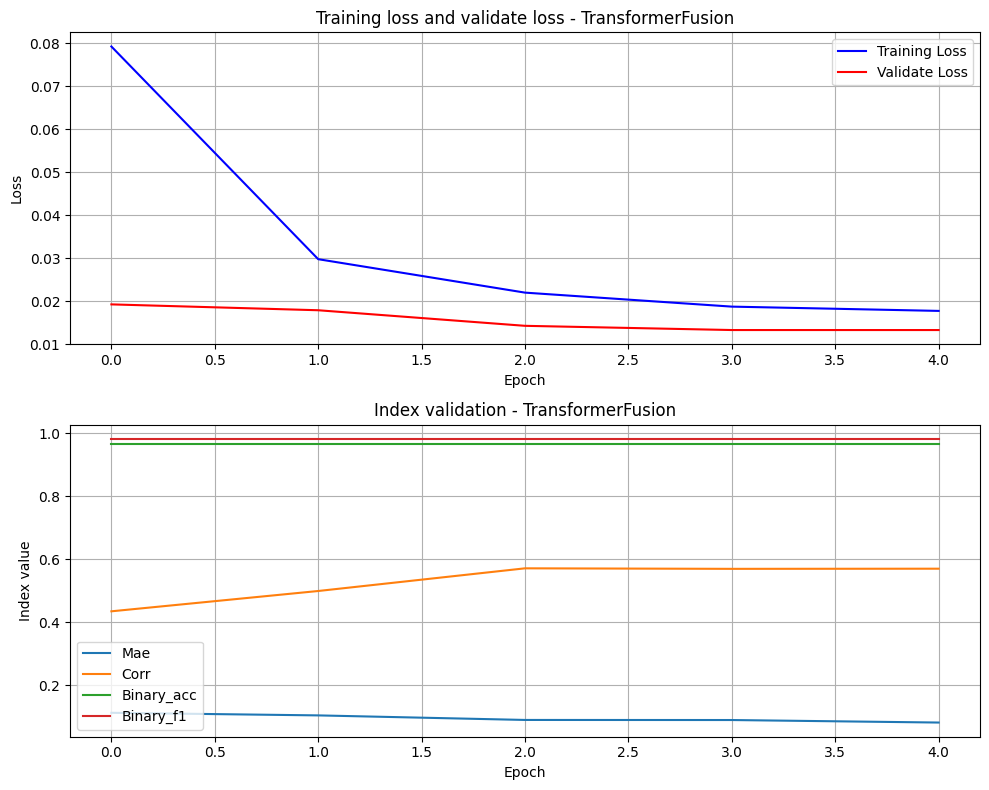

<function plot_training_curves at 0x7e7985955760>


In [ ]:
plot_training_curves(
      train_losses, val_losses, val_metrics_list,
      save_path=str(plot_dir / f"training_curves_{model_name.lower()}_av.png"),
      model_name=model_name
  )

print(plot_training_curves)

Creating model comparison chart...
Model comparison chart saved to content/plots/model_comparison_av.png


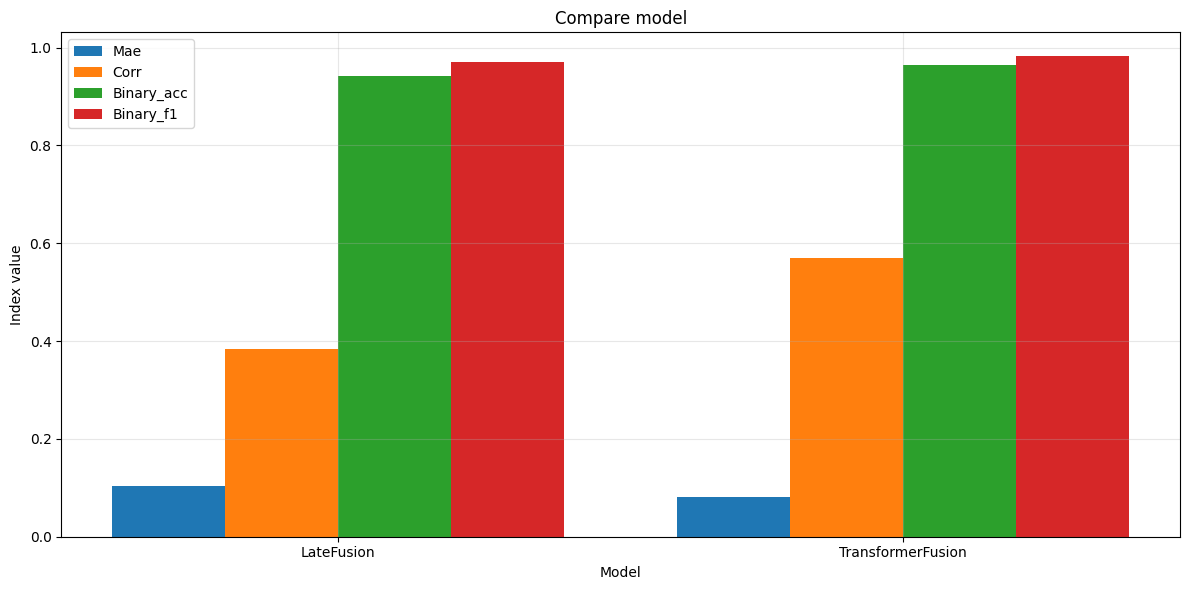

<function plot_results_summary at 0x7e7985957ce0>
Evaluating the best model (TransformerFusion) in val set...
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32, 768])
visual_features shape: torch.Size([32, 35])
Fused shape: torch.Size([32, 256])
text_features shape: torch.Size([32,

In [ ]:
print("Creating model comparison chart...")
plot_results_summary(results, str(plot_dir / "model_comparison_av.png"))
print(plot_results_summary)
# Đánh giá mô hình tốt nhất trên tập kiểm tra
best_model_name = min(results, key=lambda x: results[x]["mae"])
print(f"Evaluating the best model ({best_model_name}) in val set...")
trainer = Trainer(models[best_model_name], train_loader, val_loader, test_loader)
test_loss, test_metrics = trainer.validate(0)
print(f"Test results for {best_model_name}: Loss: {test_loss:.4f}, MAE: {test_metrics['mae']:.4f}, Corr: {test_metrics['corr']:.4f}, Binary Acc: {test_metrics['binary_acc']:.4f}, Binary F1: {test_metrics['binary_f1']:.4f}")


In [ ]:
table = PrettyTable()
table.field_names = ["Model", "MAE", "Corr", "Binary Acc","Accuracy" "Binary F1"]
for model_name, metrics in results.items():
    table.add_row([model_name] + [metrics[metric] for metric in ["mae", "corr", "binary_acc", "binary_f1"]])
print(table)

+-------------------+---------------------+---------------------+------------+--------------------+
|       Model       |         MAE         |         Corr        | Binary Acc | AccuracyBinary F1  |
+-------------------+---------------------+---------------------+------------+--------------------+
|     LateFusion    | 0.10325101763010025 | 0.38286336326128706 | 0.94140625 | 0.9698189134808853 |
| TransformerFusion | 0.08131558448076248 |  0.5701004013611962 | 0.96484375 | 0.9821073558648111 |
+-------------------+---------------------+---------------------+------------+--------------------+
